### An example for a 2D dataset classification by nerual networks 

We partition a 2D domain, $D$, into $m$ subdomains $D_i$ for $i=1,2,\ldots, m$ such that
\begin{equation}
  D = \bigcup_{i=1}^{m} D_i, \quad D_i \cap D_j = \emptyset \mbox{ for } i\neq j,
\label{partition} \tag{1}
\end{equation}
We then define a function, $f^*: D \subset R^d \rightarrow R$, by
$$        f^*(\mathbf{x}) = \alpha_i, \quad \mathbf{x} \in D_i \quad \mbox{for } i=1,2,\ldots, m. $$

One typical data classification problem is to learn the domain partition \eqref{partition} from a given dataset, ${\cal D}_i$, satisfying that
\begin{equation}
  {\cal D}= \bigcup_{i=1}^{m} {\cal D}_i, \quad {\cal D}_i \cap {\cal D}_j = \emptyset \mbox{ for } i\neq j,
\label{partitionData} \tag{2}
\end{equation}
where ${\cal D}_i$ is a set of pairs $(\mathbf{x}, y)$ with $\mathbf{x}\in D_i$ and $y=\alpha_i$.

In this example, we set $d=2$ and generate the dataset ${\cal D}$ using $m$ spiral curves defined as follows:

1. Partition the interval $[0, 2\pi]$ into $m$ subintervals $[(i-1)\tau, i \tau]$ for $i=1,2,\ldots, m$. Here $\tau=2\pi/m$, which is the length of each subinterval. 
2. Let $0\leq t \leq 1$ and generate $N$ numbers $t_j = j/N$ for $j=0, 1, \ldots, N$.
3. Let $\theta(t) = (i-1)\tau + \tau t$ for $0\leq t \leq 1$ such that $\theta(t) \in [(i-1)\tau, i \tau]$ and generate $N$ numbers $\theta_j = (i-1)\tau + \tau t_j$ for $j=0, 1, \ldots, N$.
4. Define the $i$th spiral curve on the subintervals $[(i-1)\tau, i \tau]$ by the parameter equations:
\begin{align}
   x_1 &= t \sin(\tau(t+i-1)), \\
   x_2 &= t \cos(\tau(t+i-1)), \quad t\in [0, 1] \mbox{ for } i=1,2, \ldots, m,
\label{spiralEqs} \tag{3}
\end{align}
where $t$ is the parameter and $\mathbf{x}=(x_1, x_2) \in D_i \subset R^2$. 
5. We generate $N$ points $\mathbf{x}_j =(x_{j1}, x_{j2}) \in D_i$ for $i=1,2, \ldots, m$ by 
\begin{align}
   x_{j1} &= t_j \sin(\tau(t_j+i-1)), \\
   x_{j2} &= t_j \cos(\tau(t_j+i-1)) \quad \mbox{with $t_j=j/N$ for } j=0, 1, 2, \ldots,N, 
\label{spiralData} \tag{4}
\end{align}
resulting in the $i$th dataset ${\cal D}_i =\{ (\mathbf{x}_j, y_j) | j=0, 1, 2, \ldots,N \}$ with $y_j=i$. 

### Note: 

- In the program, we set $\theta = \tau(t+i)$ for $i=0, 1, 2, \ldots, m-1$ for $\theta \in [\tau i, \tau (i+1)]$. We then generate a uniform partition of this interval with $\theta_j = \tau(t_j+i)$ for $j=0, 1, 2, \ldots, N$. 
- This notebook is a modified version of the notebook from the NYU deep learning course. See the link for more information: [https://atcold.github.io/pytorch-Deep-Learning/en/week02/02-3/](https://atcold.github.io/pytorch-Deep-Learning/en/week02/02-3/). 
- Dr. Dexuan Xie on Oct. 21, 2021 for Math 801: Add the construction part of the datasets and make some changes to match the description given here.


In [24]:
import random
import torch
from torch import nn, optim
import math
from IPython import display
from matplotlib import pyplot as plt
import numpy as np

import time

In [25]:
def set_default(figsize=(10, 10), dpi=100):
    plt.style.use(['dark_background', 'bmh'])
    plt.rc('axes', facecolor='k')
    plt.rc('figure', facecolor='k')
    plt.rc('figure', figsize=figsize, dpi=dpi)


def plot_data(X, y, d=0, auto=False, zoom=1):
    X = X.cpu()
    y = y.cpu()
    # Use c = y to color each point
    plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
    plt.axis('square')
    plt.axis(np.array((-1.1, 1.1, -1.1, 1.1)) * zoom)
    if auto is True: plt.axis('equal')
    #plt.axis('off')

    _m, _c = 0, '.15'
    plt.axvline(0, ymin=_m, color=_c, lw=1, zorder=0)
    plt.axhline(0, xmin=_m, color=_c, lw=1, zorder=0)

def plot_model(X, y, model):
    model.cpu()
    mesh = np.arange(-1.1, 1.1, 0.01)
    xx, yy = np.meshgrid(mesh, mesh)
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
        Z = model(data).detach()
    Z = np.argmax(Z, axis=1).reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3)
    plot_data(X, y)
    
def plot_model2(X, y, model, r2 = 5, step = 10):
    """
    Plot the subdomain partition predicted by the neuaral network
    """
    model.cpu()
    mesh = np.arange(-r2 -0.5, r2 + 0.5, 0.01)
    xx, yy = np.meshgrid(mesh, mesh)
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
        Z = model(data).detach()
    Z = np.argmax(Z, axis=1).reshape(xx.shape)
    # Plot the sample points of each subdomain
    # plt.scatter(X.numpy()[:-1:step, 0], X.numpy()[:-1:step, 1], c=y[:-1:step], s=20, cmap=plt.cm.Spectral)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3)
    plt.ylabel('$x_2$')
    plt.xlabel('$x_1$')
    plt.title('Predicted domain partiton')

### Implement a Modified Activation Function


One of the examples of such simple functions is Sigmoid Linear Unit or just SiLU also known as Swish-1:

   S𝑖𝐿𝑈(𝑥)= x / (1 + exp(x))


In [26]:
# Set the figure ploting parameters by using the defaults given in set_default()
set_default()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Generate the training data set that contains $m$ subclasses.

In [27]:
# Set a seed for the random number generator
seed = 12345
random.seed(seed)
torch.manual_seed(seed)

# Input parameters.
N = 500  # number of sample points in each subdomain D_i
D = 2  # dimensions
m = 3  # number of sub-classes
H1 = 20  # number of neuros of the first hidden layer
H2 = 10  # number of neuros of the second hidden layer
H3 = 10  # number of neuros of the third hidden layer
noice = 0.4 # noice rate

# Allocation of the memories 
#  X: a 2D array for the matrix of order NC x D
#  y: a 1D array for the vector of order NC
X = torch.zeros(N * m, D).to(device)
y = torch.zeros(N * m, dtype=torch.long).to(device)

# Generate a uniform partition of interval [0, 1] for parameter variable t
#  t_j = j/N for j=0, 1, 2, ..., N
t = torch.linspace(0, 1, N)

# Length of each subinterval 
tau = 2 * math.pi / m

In [28]:
# Generate the m sub-datasets such that each subdata set contains N sample points
for i in range(m):  # Here i = 0, 1, 2, ..., m-1
    j = 0
    # Generate N numbers in the subinterval [tau*i, tau*(i+1)] with tau = 2pi/C
    theta = torch.linspace(tau * i, tau * (i + 1), N) + torch.randn(N) * noice
    # Generate the N sample points in the $i$th subdomain D_i
    for ix in range(N * i, N * (i + 1)):
        X[ix] = t[j] * torch.FloatTensor((
            math.sin(theta[j]), math.cos(theta[j])
        ))
        y[ix] = i
        j += 1

print("Shapes:")
print("X:", tuple(X.size()))
print("y:", tuple(y.size()))
#print('y=', y)
#print('X=', X)

Shapes:
X: (1500, 2)
y: (1500,)


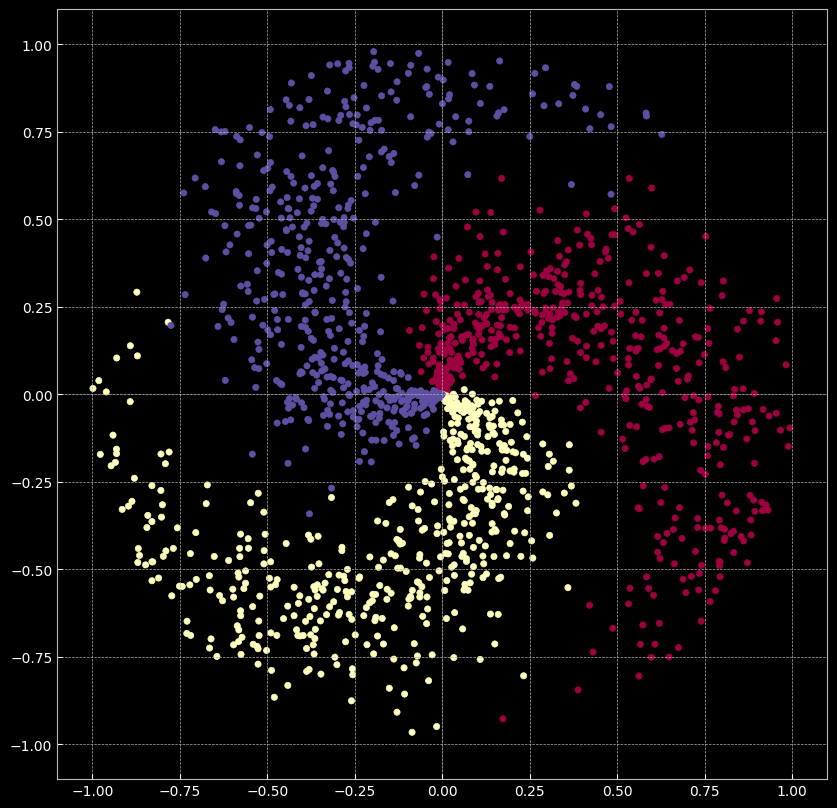

In [29]:
# visualise the data
plot_data(X, y)

### Linear model

[Linear model in PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) defines a linear transformation to the incoming data vector $x$ by
$$  y = xA^T + b,$$
where $y\in R^l$,  $x\in R^d$, $A$ is a matrix of $l\times d$, and $b\in R^l$. Here $n$ denotes as in_features, $l$ denotes as out_features. We need to determine the weight matrix $A$ and bias vector $b$ optimally by minimizing a loss function  $L(A, b)$.

Example:

```
CLASS torch.nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)

>>> in_features = 20   # d=20
>>> out_features = 30  # l = 30
>>> m = nn.Linear(in_features, out_features)
>>> input = torch.randn(128, in_features)  # input is a training data set as an array of N x d. 
                                           #    N is the number of points (x,y)
>>> output = m(input)   # output is the predicted function values: 
                        #         output = (y_1, y_2, ..., y_N) with y_i in R^l
>>> print(output.size())
torch.Size([128, 30])
```

In [30]:
learning_rate = 1e-3
lambda_l2 = 1e-5

In [ ]:
'''
# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Define some constants
D = 2 # Input dimension
m = 2 # Output dimension
N = 10 # Number of samples

# Generate some random data
X = torch.randn(N, D)
y = torch.randint(0, m, (N,))

# Convert to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X = X.to(device)
y = y.to(device)

# Set learning rate and L2 regularization lambda
learning_rate = 0.1
lambda_l2 = 0.01

# Define activation functions
activation_functions = [nn.ReLU(), nn.RReLU(), nn.ReLU6(), nn.Tanh(),
                        nn.SELU(), nn.CELU(), nn.GELU(), nn.Sigmoid(),
                        nn.Softplus(), nn.Softmin(), nn.Softmax()]

# Define table headers
print("{:<12} {:<8} {:<8}".format("Activation", "Loss", "Accuracy"))

# Training
for activation_function in activation_functions:
    
    # Create linear model with activation function
    linear_model = nn.Sequential(nn.Linear(D, m), activation_function).to(device)

    # Define loss function and optimizer
    Loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(linear_model.parameters(), lr=learning_rate, weight_decay=lambda_l2)

    # Train model for 1000 epochs
    for t in range(1000):
        
        # Feed forward to get the logits
        y_pred = linear_model(X)
        
        # Compute the loss and accuracy
        loss = Loss(y_pred, y)
        score, predicted = torch.max(y_pred, 1)
        acc = (y == predicted).sum().float() / len(y)
        
        # zero the gradients before running
        # the backward pass.
        optimizer.zero_grad()
        
        # Backward pass to compute the gradient
        # of loss w.r.t our learnable params. 
        loss.backward()

        # Update params
        optimizer.step()
        
        # Print results for last epoch only
        if t == 999:
            print("{:<12} {:<8.6f} {:<8.3f}".format(str(activation_function.__class__.__name__), loss.item(), acc))

'''
'''
from prettytable import PrettyTable

# Define the table headers
table = PrettyTable(["Activation Function", "Epoch", "Loss", "Accuracy"])

# Loop over each activation function
for activation_function in [nn.ReLU(), nn.RReLU(), nn.ReLU6(), nn.Tanh(), nn.SELU(),
                            nn.CELU(), nn.GELU(), nn.Sigmoid(), nn.Softplus(), nn.Softmin(),
                            nn.Softmax()]:
    # Define the linear model
    linear_model = nn.Sequential(nn.Linear(D, m), activation_function)
        # A multipler layer perceptron with two hidden layers
#     nn.Linear(D, H1),
#     nn.Linear(H1, H2),
#     nn.Linear(H2, H3),
#     nn.Linear(H3, C)
    
    #activation_function
    linear_model.to(device)

    # Define the loss function
    Loss = nn.CrossEntropyLoss()

    # Define the optimizer
    optimizer = torch.optim.SGD(linear_model.parameters(), lr=learning_rate, weight_decay=lambda_l2)

    # Train the model for 1000 epochs
    for t in range(1000):
        y_pred = linear_model(X)
        loss = Loss(y_pred, y)
        score, predicted = torch.max(y_pred, 1)
        acc = (y == predicted).sum().float() / len(y)
        table.add_row([str(activation_function), t, round(loss.item(), 6), round(acc.item(), 3)])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Print the table
print(table)
'''

# nn package to create our linear model
# each Linear module has a weight and bias
# nn package to create our linear model
# each Linear module has a weight and bias
linear_model = nn.Sequential(
    # A single layer perceptron
    nn.Linear(D, m)
    # A multipler layer perceptron with two hidden layers
#     nn.Linear(D, H1),
#     nn.Linear(H1, H2),
#     nn.Linear(H2, H3),
#     nn.Linear(H3, C)
    
    #activation_function   
)
linear_model.to(device) #Convert to CUDA

# nn package has different loss functions.
# We can use the Mean Squared Error Loss Function: 
#     Loss = torch.nn.MSELoss()
#  or use the cross entropy loss function:
#     Loss = torch.nn.CrossEntropyLoss()

#Loss = torch.nn.MSELoss()
Loss = torch.nn.CrossEntropyLoss()

# we use the optim package to apply
# stochastic gradient descent for our parameter updates
optimizer = torch.optim.SGD(linear_model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# Training
for t in range(1000):
    
    # Feed forward to get the logits
    y_pred = linear_model(X)
    
    # Compute the loss and accuracy
    loss = Loss(y_pred, y)
    score, predicted = torch.max(y_pred, 1)
    acc = (y == predicted).sum().float() / len(y)
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), acc))
    display.clear_output(wait=True)
    
    # zero the gradients before running
    # the backward pass.
    optimizer.zero_grad()
    
    # Backward pass to compute the gradient
    # of loss w.r.t our learnable params. 
    loss.backward()
    
    # Update params
    optimizer.step()

In [31]:
#activation_function = nn.RReLU()
#activation_function = nn.ReLU6()
#activation_function = nn.Tanh()
#activation_function = nn.SELU()
#activation_function = nn.CELU()
#activation_function = nn.GELU()
#activation_function = nn.Sigmoid(),
#activation_function = nn.Softplus()
#activation_function = nn.Softmin()
#activation_function = nn.Softmax()
#activation_function = nn.ReLU()

# nn package to create our linear model
# each Linear module has a weight and bias
linear_model = nn.Sequential(
    # A single layer perceptron
    nn.Linear(D, m)
    # A multipler layer perceptron with two hidden layers
#     nn.Linear(D, H1),
#     nn.Linear(H1, H2),
#     nn.Linear(H2, H3),
#     nn.Linear(H3, C)
    
    #activation_function   
)
linear_model.to(device) #Convert to CUDA

# nn package has different loss functions.
# We can use the Mean Squared Error Loss Function: 
#     Loss = torch.nn.MSELoss()
#  or use the cross entropy loss function:
#     Loss = torch.nn.CrossEntropyLoss()
#Loss = torch.nn.MSELoss()
Loss = torch.nn.CrossEntropyLoss()

# we use the optim package to apply
# stochastic gradient descent for our parameter updates
optimizer = torch.optim.SGD(linear_model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# Training
for t in range(1000):
    
    # Feed forward to get the logits
    y_pred = linear_model(X)
    
    # Compute the loss and accuracy
    loss = Loss(y_pred, y)
    score, predicted = torch.max(y_pred, 1)
    acc = (y == predicted).sum().float() / len(y)
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), acc))
    display.clear_output(wait=True)
    
    # zero the gradients before running
    # the backward pass.
    optimizer.zero_grad()
    
    # Backward pass to compute the gradient
    # of loss w.r.t our learnable params. 
    loss.backward()
    
    # Update params
    optimizer.step()


[EPOCH]: 999, [LOSS]: 1.075789, [ACCURACY]: 0.466


Sequential(
  (0): Linear(in_features=2, out_features=3, bias=True)
)


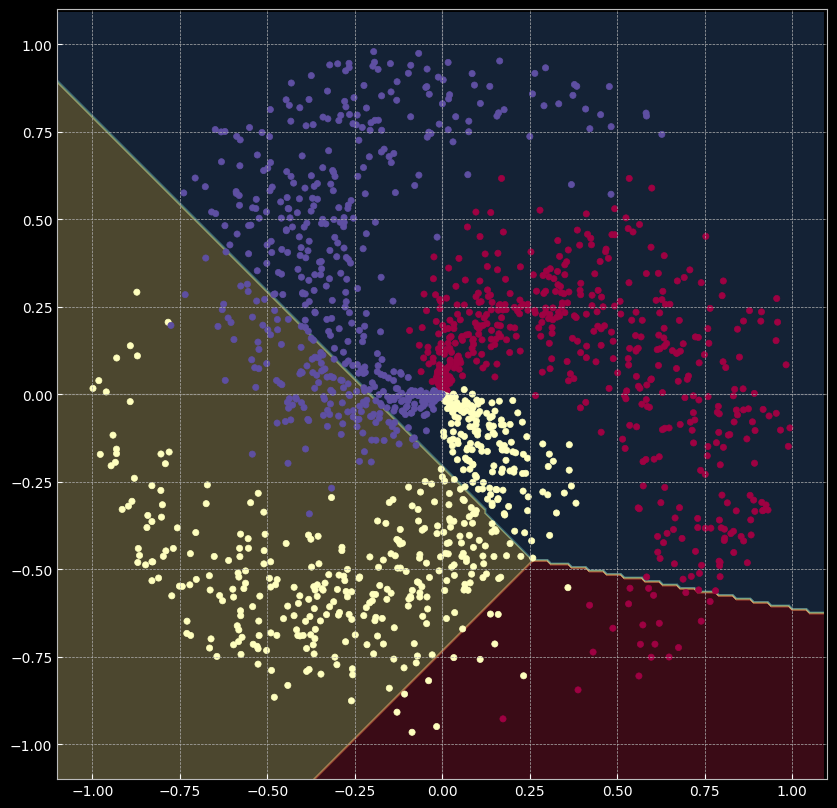

In [32]:
# Plot trained model
print(linear_model)
plot_model(X, y, linear_model)

### Numerical test results for a hidden-layered network with an activation function

Activation functions in PyTorch can be found in the website [Non-linear Activations](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) and [the others](https://pytorch.org/docs/stable/nn.html#non-linear-activations-other). Here are the test results produced by using typical atication functions:

- [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html?highlight=nn%20relu#torch.nn.ReLU)
```
[EPOCH]: 0, [LOSS]: 1.111339, [ACCURACY]: 0.333
[EPOCH]: 15, [LOSS]: 0.104682, [ACCURACY]: 0.953
Training the nonlinear model takes 0.0617 seconds
```

- [RELU6](https://pytorch.org/docs/stable/generated/torch.nn.ReLU6.html)
```
[EPOCH]: 0, [LOSS]: 1.103714, [ACCURACY]: 0.194
[EPOCH]: 17, [LOSS]: 0.081547, [ACCURACY]: 0.975
Training the nonlinear model takes 0.0731 seconds
```

- [RRELU](https://pytorch.org/docs/stable/generated/torch.nn.RReLU.html)
```
[EPOCH]: 0, [LOSS]: 1.119960, [ACCURACY]: 0.319
[EPOCH]: 16, [LOSS]: 0.086450, [ACCURACY]: 0.963
Training the nonlinear model takes 0.0866 seconds
```

- [SELU](https://pytorch.org/docs/stable/generated/torch.nn.SELU.html)
```
[EPOCH]: 0, [LOSS]: 1.155280, [ACCURACY]: 0.333
[EPOCH]: 14, [LOSS]: 0.125699, [ACCURACY]: 0.952
Training the nonlinear model takes 0.0688 seconds
```
- [CELU](https://pytorch.org/docs/stable/generated/torch.nn.CELU.html)
```
[EPOCH]: 0, [LOSS]: 1.129845, [ACCURACY]: 0.105
[EPOCH]: 14, [LOSS]: 0.135331, [ACCURACY]: 0.959
Training the nonlinear model takes 0.0695 seconds
```

- [GELU](https://pytorch.org/docs/stable/generated/torch.nn.GELU.html)
```
[EPOCH]: 0, [LOSS]: 1.110101, [ACCURACY]: 0.333
[EPOCH]: 15, [LOSS]: 0.132183, [ACCURACY]: 0.951
Training the nonlinear model takes 0.0720 seconds
```

- [SIGMOID](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html)
```
[EPOCH]: 0, [LOSS]: 1.150436, [ACCURACY]: 0.333
[EPOCH]: 64, [LOSS]: 0.161114, [ACCURACY]: 0.963
Training the nonlinear model takes 0.2528 seconds
```

- [TANH](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html)
```
[EPOCH]: 0, [LOSS]: 1.103973, [ACCURACY]: 0.203
[EPOCH]: 13, [LOSS]: 0.114222, [ACCURACY]: 0.958
Training the nonlinear model takes 0.0603 seconds
```

- [SOFTPLUS](https://pytorch.org/docs/stable/generated/torch.nn.Softplus.html): A smooth approximation to the ReLU function and can be used to constrain the output of a machine to always be positive.
```
[EPOCH]: 0, [LOSS]: 1.158936, [ACCURACY]: 0.333
[EPOCH]: 42, [LOSS]: 0.215517, [ACCURACY]: 0.951
Training the nonlinear model takes 0.2650 seconds
```

- [SOFTMIN](https://pytorch.org/docs/stable/generated/torch.nn.Softmin.html)
```
[EPOCH]: 0, [LOSS]: 1.116268, [ACCURACY]: 0.333
[EPOCH]: 63, [LOSS]: 0.264826, [ACCURACY]: 0.950
Training the nonlinear model takes 0.2988 seconds
```

- [SOFTMAX](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html)
```
[EPOCH]: 0, [LOSS]: 1.099186, [ACCURACY]: 0.333
[EPOCH]: 63, [LOSS]: 0.162910, [ACCURACY]: 0.951
Training the nonlinear model takes 0.2932 seconds
```

- [LogSoftmax](https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html)
```
[EPOCH]: 0, [LOSS]: 2.095248, [ACCURACY]: 0.333
[EPOCH]: 85, [LOSS]: 0.173697, [ACCURACY]: 0.957
Training the nonlinear model takes 0.3926 seconds
```



In [33]:
class ReLU(torch.nn.Module):
    def __init__(self, inplace=False):
        super().__init__()
        self.inplace = inplace

    def forward(self, x):
        return torch.nn.functional.relu(x, inplace=self.inplace)


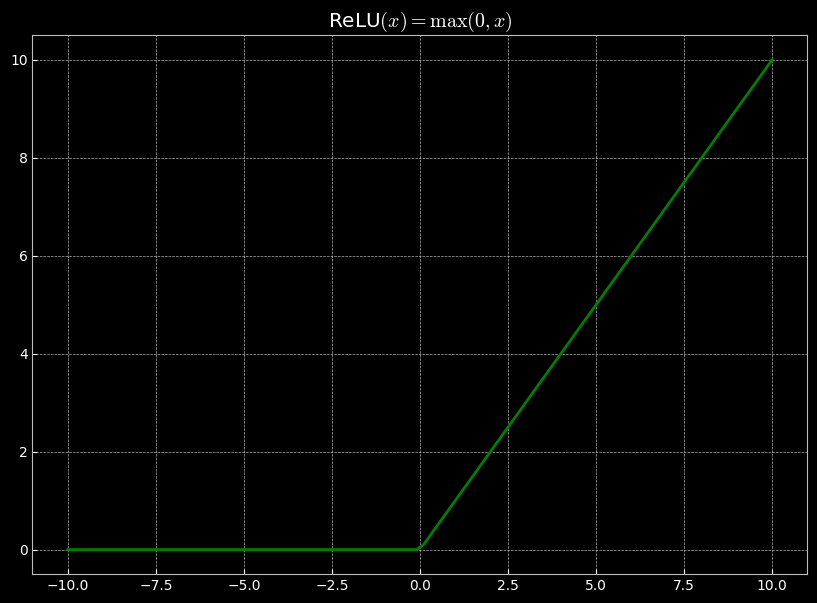

In [34]:
def relu(x):
    return np.maximum(0, x)

fig = plt.figure(figsize=(10,7))
ax = plt.axes()

plt.title(r"ReLU$(x) = \max(0,x)$")

xx = np.linspace(-10, 10, 100)
ax.plot(xx, relu(xx), '-g')


In [35]:
class ReLU6(torch.nn.Module):
    def forward(self, x):
        return torch.clamp(x, 0, 6)


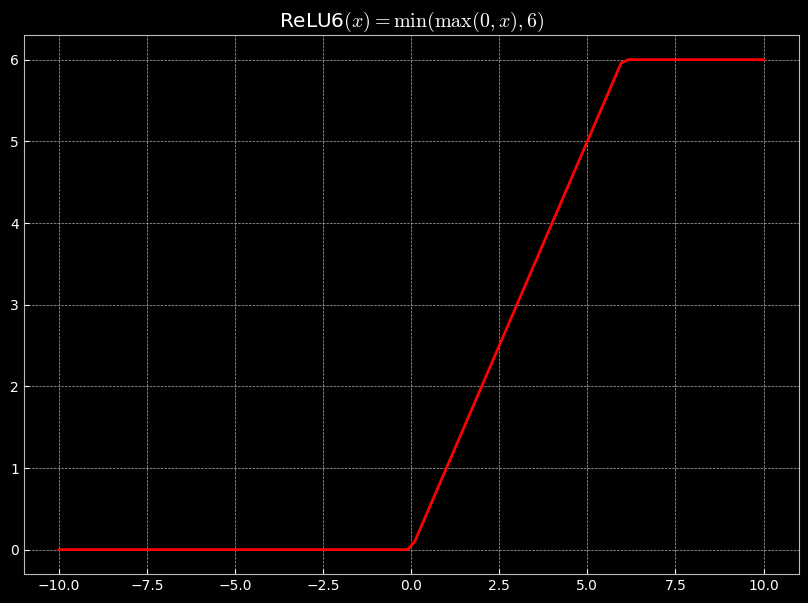

In [36]:
def relu6(x):
    return np.minimum(np.maximum(0, x), 6)

fig = plt.figure(figsize=(10,7))
ax = plt.axes()

plt.title(r"ReLU6$(x) = \min(\max(0,x), 6)$")

xx = np.linspace(-10, 10, 100)
ax.plot(xx, relu6(xx), '-r')


In [37]:
class RReLU(torch.nn.Module):
    def __init__(self, lower=0.125, upper=0.3333333333333333, inplace=False):
        super().__init__()
        self.lower = lower
        self.upper = upper
        self.inplace = inplace

    def forward(self, x):
        if self.training:
            a = torch.empty(x.size(), device=x.device).uniform_(self.lower, self.upper)
        else:
            a = (self.lower + self.upper) / 2

        return torch.nn.functional.relu(x, inplace=self.inplace) + a * torch.nn.functional.relu(-x, inplace=self.inplace)


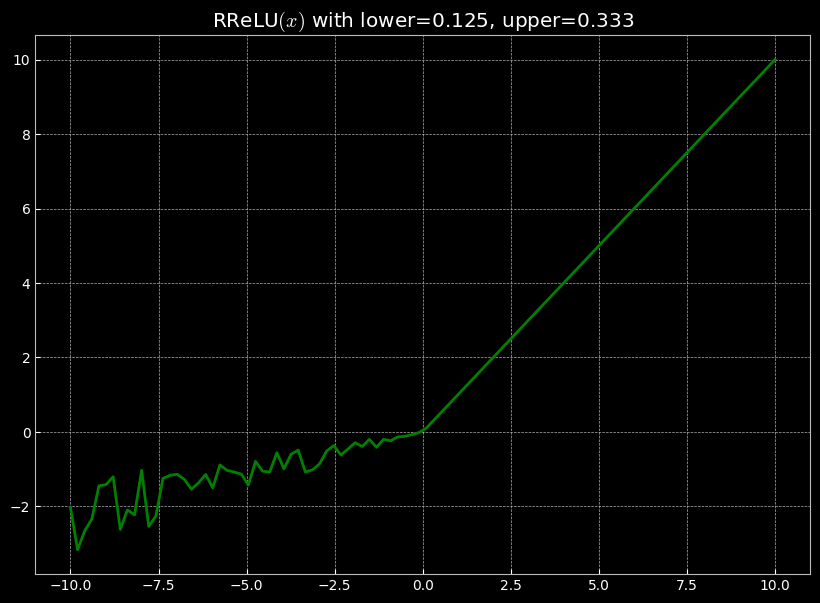

In [38]:
def rrelu(x, lower=0.125, upper=0.333):
    if x >= 0:
        return x
    else:
        return np.random.uniform(lower, upper) * x

fig = plt.figure(figsize=(10,7))
ax = plt.axes()

plt.title(r"RReLU$(x)$ with lower={}, upper={}".format(0.125, 0.333))

xx = np.linspace(-10, 10, 100)
yy = [rrelu(x, lower=0.125, upper=0.333) for x in xx]
ax.plot(xx, yy, '-g')


In [39]:
class SELU(torch.nn.Module):
    """
    Applies the Scaled Exponential Linear Units (SELU) function to an input Tensor.
    SELU activation function is defined as: 
    SELU(x) = scale * (max(0, x) + min(0, alpha * (exp(x) - 1)))
    with alpha=1.6732632423543772848170429916717 and scale=1.0507009873554804934193349852946
    
    Reference: "Self-Normalizing Neural Networks" https://arxiv.org/pdf/1706.02515.pdf
    """

    def __init__(self, inplace=False):
        super().__init__()
        self.inplace = inplace

    def forward(self, x):
        alpha = 1.6732632423543772848170429916717
        scale = 1.0507009873554804934193349852946
        if self.inplace:
            return torch.selu_(x, alpha=alpha, scale=scale)
        else:
            return torch.selu(x, alpha=alpha, scale=scale)


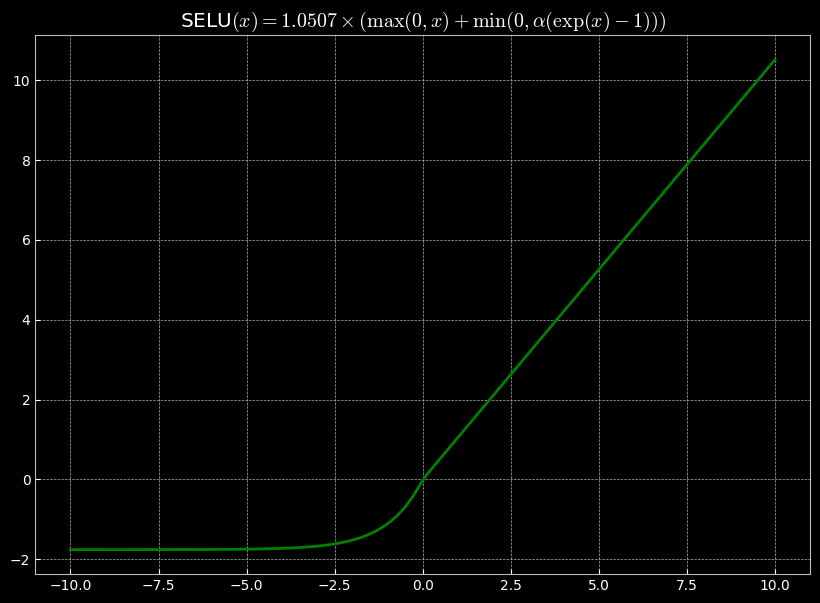

In [40]:
def selu(x):
    alpha = 1.6732632423543772848170429916717
    scale = 1.0507009873554804934193349852946
    return scale * (np.maximum(0, x) + np.minimum(0, alpha * (np.exp(x) - 1)))

fig = plt.figure(figsize=(10,7))
ax = plt.axes()

plt.title(r"SELU$(x) = 1.0507\times(\max(0,x)+\min(0,\alpha(\exp(x)-1)))$")

xx = np.linspace(-10, 10, 100)
ax.plot(xx, selu(xx), '-g')


In [41]:
class GELU(nn.Module):
    def __init__(self, approximate='none'):
        super().__init__()
        self.approximate = approximate

    def forward(self, x):
        if self.approximate == 'none':
            return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))
        elif self.approximate == 'tanh':
            return 0.5 * x * (1.0 + torch.tanh(0.79788456 * (x + 0.044715 * torch.pow(x, 3))))
        else:
            raise ValueError('Invalid approximate method specified for GELU activation')


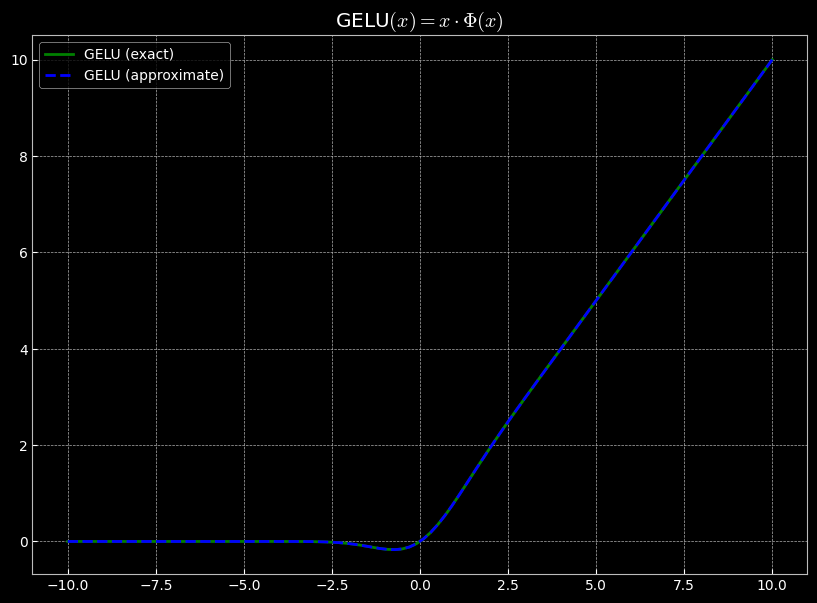

In [42]:
def gelu(x, approximate='none'):
    if approximate == 'none':
        return 0.5 * x * (1 + np.tanh(np.sqrt(2/np.pi) * (x + 0.044715 * x**3)))
    elif approximate == 'tanh':
        return 0.5 * x * (1 + np.tanh(0.79788456 * (x + 0.044715 * x**3)))

fig = plt.figure(figsize=(10,7))
ax = plt.axes()

plt.title(r"GELU$(x) =  x \cdot \Phi(x)$ ")

xx = np.linspace(-10, 10, 100)
ax.plot(xx, gelu(xx), '-g', label='GELU (exact)')
ax.plot(xx, gelu(xx, approximate='tanh'), '--b', label='GELU (approximate)')

plt.legend()


In [43]:
class CELU(torch.nn.Module):
    def __init__(self, alpha=1.):
        super().__init__()
        self.alpha = alpha

    def forward(self, x):
        return torch.max(x, torch.zeros_like(x)) + \
               torch.min(x, torch.zeros_like(x) + self.alpha * (torch.exp(x / self.alpha) - 1))


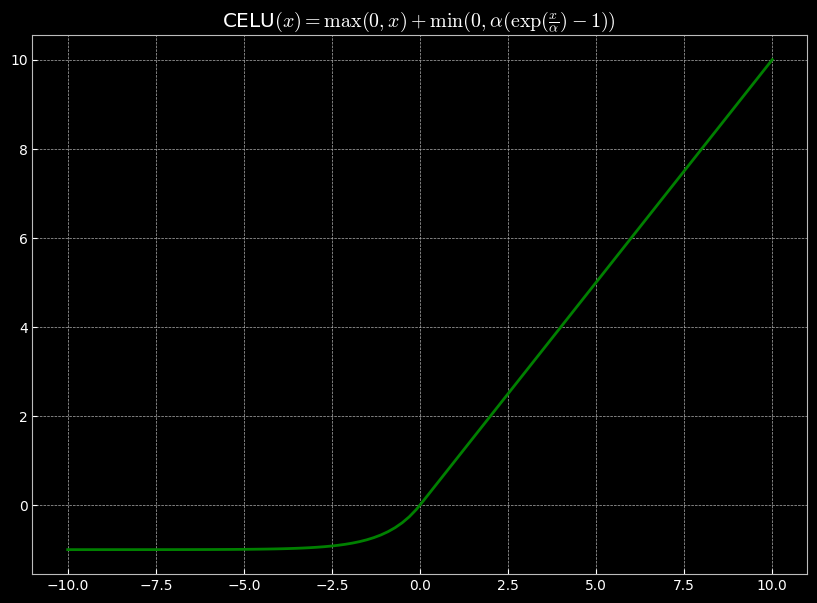

In [44]:
def celu(x, alpha=1.):
    return np.maximum(0, x) + np.minimum(0, alpha * (np.exp(x/alpha) - 1))

fig = plt.figure(figsize=(10,7))
ax = plt.axes()

plt.title(r"CELU$(x) =  \max(0,x)+\min(0,\alpha(\exp(\frac{x}{\alpha})-1))$ ")

xx = np.linspace(-10, 10, 100)
ax.plot(xx, celu(xx), '-g')


## Implementing Simple Activation Functions
The most simple activation functions
* are differentiable and don't need the manual implementation of the backward step,
* don't have any trainable parameters, all their parameters are set in advance.

One of the examples of such simple functions is Sigmoid Linear Unit or just [SiLU](https://arxiv.org/pdf/1606.08415.pdf) also known as Swish-1:

$$SiLU(x) = x * \sigma(x) = x * \frac{1}{1 + e^{-x}}$$

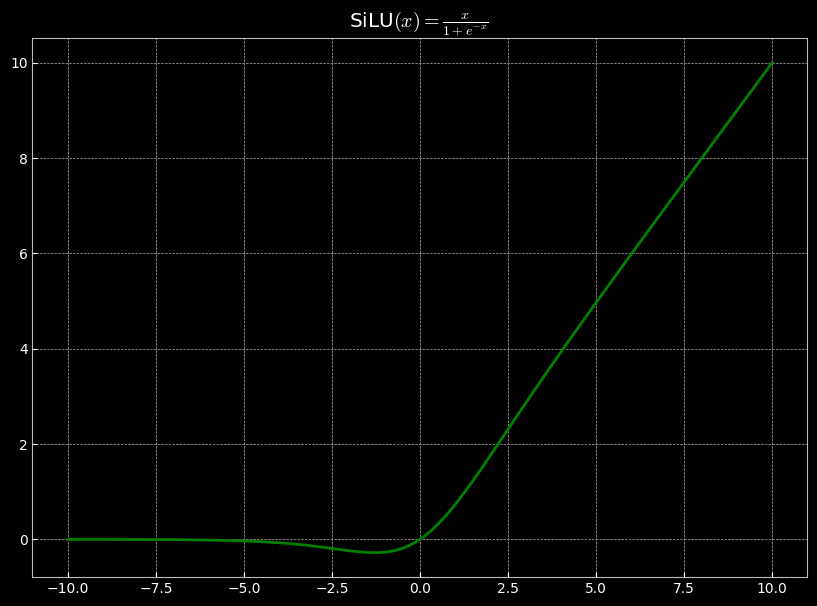

In [45]:
# Plot this function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

fig = plt.figure(figsize=(10,7))
ax = plt.axes()

plt.title(r"SiLU$(x) =  \frac{x}{1 + e^{-x}}$ ")

xx = np.linspace(-10, 10, 100)
ax.plot(xx, xx * sigmoid(xx), '-g')

In [46]:
class Tanh(nn.Module):
    '''
    Applies the Hyperbolic Tangent (Tanh) function element-wise:
    
        Tanh(x) = (exp(x) - exp(-x)) / (exp(x) + exp(-x))

    Shape:
        - Input: (N, *) where * means, any number of additional
          dimensions
        - Output: (N, *), same shape as the input

    References:
        -  PyTorch documentation:
        https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html

    Examples:
        >>> m = Tanh()
        >>> input = torch.randn(2)
        >>> output = m(input)

    '''
    def __init__(self):
        '''
        Init method.
        '''
        super().__init__() # init the base class

    def forward(self, input):
        '''
        Forward pass of the function.
        '''
        return torch.tanh(input) # simply apply the built-in PyTorch tanh function


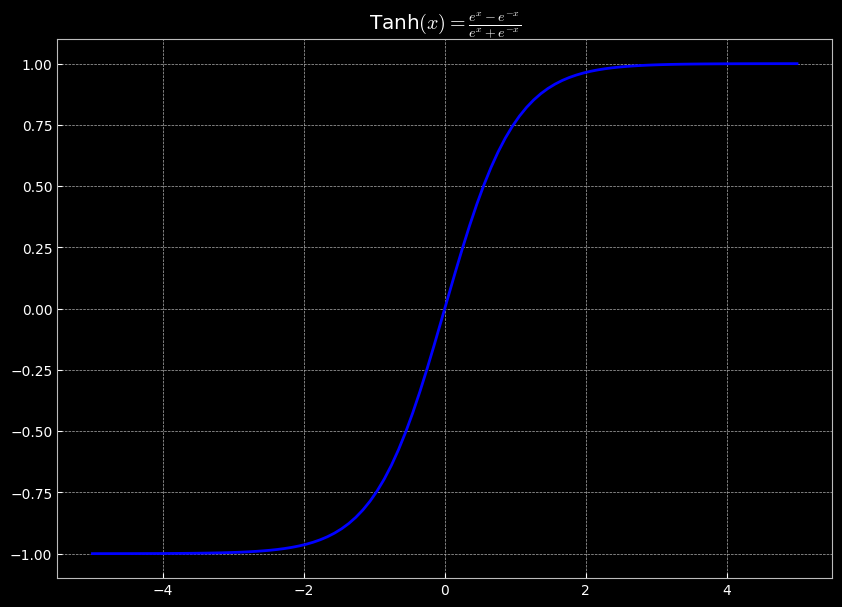

In [47]:
def tanh(x):
    return np.tanh(x)

fig = plt.figure(figsize=(10,7))
ax = plt.axes()

plt.title(r"Tanh$(x) =  \frac{e^x - e^{-x}}{e^x + e^{-x}}$")

xx = np.linspace(-5, 5, 100)
ax.plot(xx, tanh(xx), '-b')
plt.show()


In [48]:
class SoftPlus(nn.Module):
    '''
    Applies the Softplus function element-wise:
    
        Softplus(x) = 1/beta * log(1 + exp(beta * x))

    Shape:
        - Input: (N, *) where * means, any number of additional
          dimensions
        - Output: (N, *), same shape as the input

    References:
        -  PyTorch documentation:
        https://pytorch.org/docs/stable/generated/torch.nn.Softplus.html

    Examples:
        >>> m = SoftPlus(beta=1, threshold=20)
        >>> input = torch.randn(2)
        >>> output = m(input)

    '''
    def __init__(self, beta=1, threshold=20):
        '''
        Init method.
        '''
        super().__init__() # init the base class
        self.beta = beta
        self.threshold = threshold

    def forward(self, input):
        '''
        Forward pass of the function.
        '''
        if self.beta * input > self.threshold:
            return input
        else:
            return 1/self.beta * torch.log(1 + torch.exp(self.beta * input))


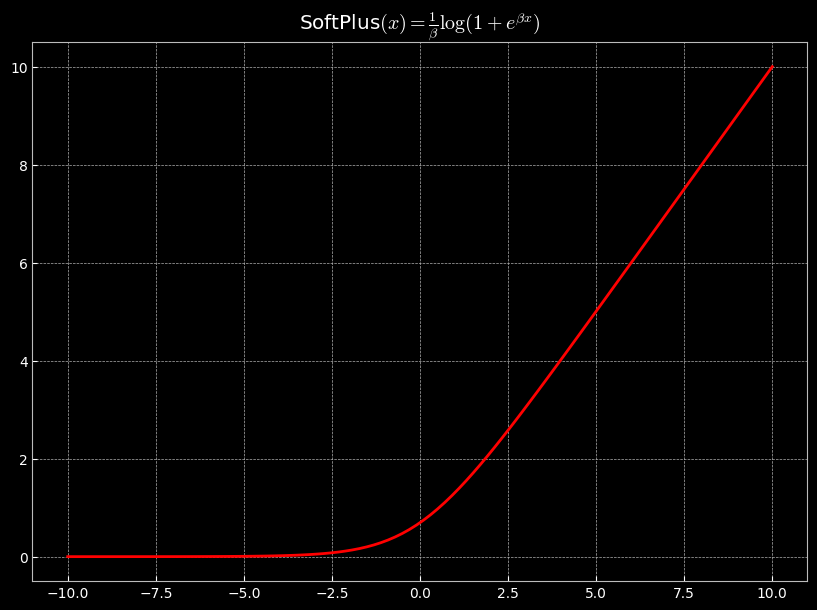

In [49]:
def softplus(x, beta=1):
    return 1/beta * np.log(1 + np.exp(beta * x))

fig = plt.figure(figsize=(10,7))
ax = plt.axes()

plt.title(r"SoftPlus$(x) =  \frac{1}{\beta} \log(1 + e^{\beta x})$")

xx = np.linspace(-10, 10, 100)
ax.plot(xx, softplus(xx), '-r')
plt.show()

In [50]:
class Softmin(torch.nn.Module):
    """
    Applies the Softmin function to an n-dimensional input Tensor,
    rescaling them so that the elements of the n-dimensional output
    Tensor lie in the range [0, 1] and sum to 1.

    Softmin is defined as:
    Softmin(xi) = exp(-xi) / ∑ j exp(-xj)
    """

    def __init__(self, dim=None):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        exp_x = torch.exp(-x)
        return exp_x / torch.sum(exp_x, dim=self.dim, keepdim=True)


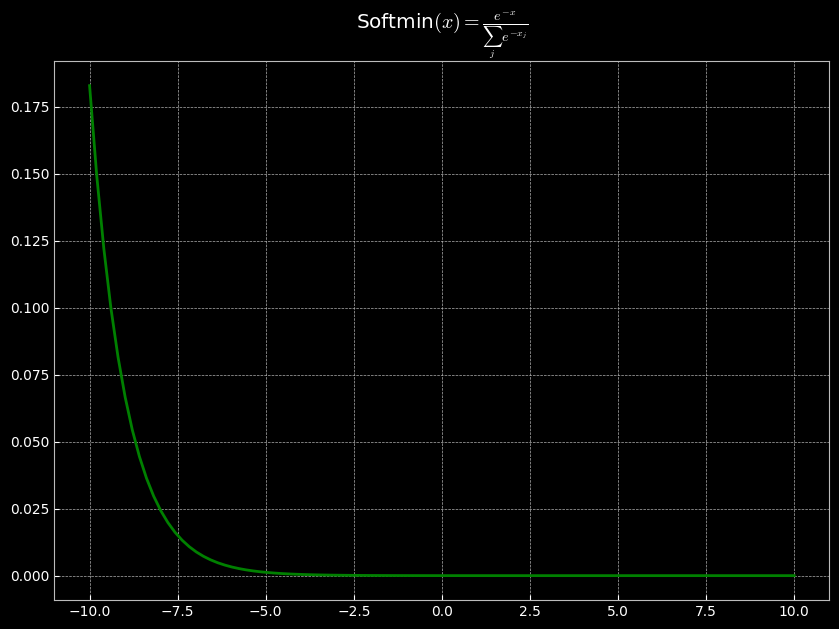

In [51]:
def softmin(x):
    exp_x = np.exp(-x)
    return exp_x / np.sum(exp_x)

fig = plt.figure(figsize=(10,7))
ax = plt.axes()

plt.title(r"Softmin$(x) = \frac{e^{-x}}{\sum_{j}e^{-x_j}}$")

xx = np.linspace(-10, 10, 100)
ax.plot(xx, softmin(xx), '-g')


In [52]:
class Softmax(torch.nn.Module):
    """
    Applies the Softmax function to an n-dimensional input Tensor,
    rescaling them so that the elements of the n-dimensional output
    Tensor lie in the range [0, 1] and sum to 1.

    Softmax is defined as:
    Softmax(xi) = exp(xi) / ∑ j exp(xj)
    """

    def __init__(self, dim=None):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        exp_x = torch.exp(x)
        return exp_x / torch.sum(exp_x, dim=self.dim, keepdim=True)


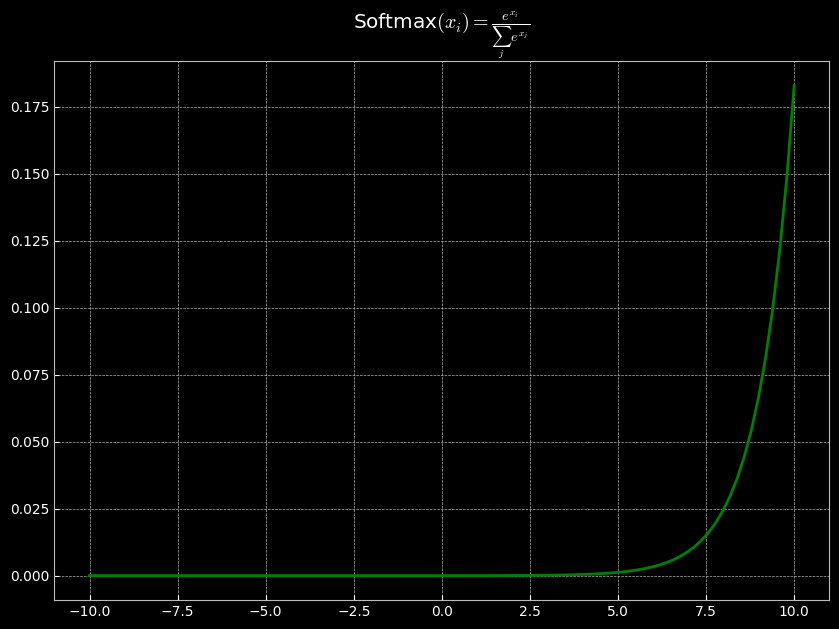

In [53]:
def softmax(x):
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x)

fig = plt.figure(figsize=(10,7))
ax = plt.axes()

plt.title(r"Softmax$(x_i) = \frac{e^{x_i}}{\sum_{j}e^{x_j}}$")

xx = np.linspace(-10, 10, 100)
ax.plot(xx, softmax(xx), '-g')


In [54]:
class LogSoftmax(torch.nn.Module):
    """
    Applies the LogSoftmax function to an n-dimensional input Tensor,
    rescaling them so that the elements of the n-dimensional output
    Tensor lie in the range [-inf, 0] and sum to 1.

    LogSoftmax is defined as:
    LogSoftmax(xi) = log(Softmax(xi))

    The main advantage of using LogSoftmax instead of Softmax is that it is more
    numerically stable, especially for large input values.
    """

    def __init__(self, dim=None):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        log_exp_x = x - torch.logsumexp(x, dim=self.dim, keepdim=True)
        return log_exp_x


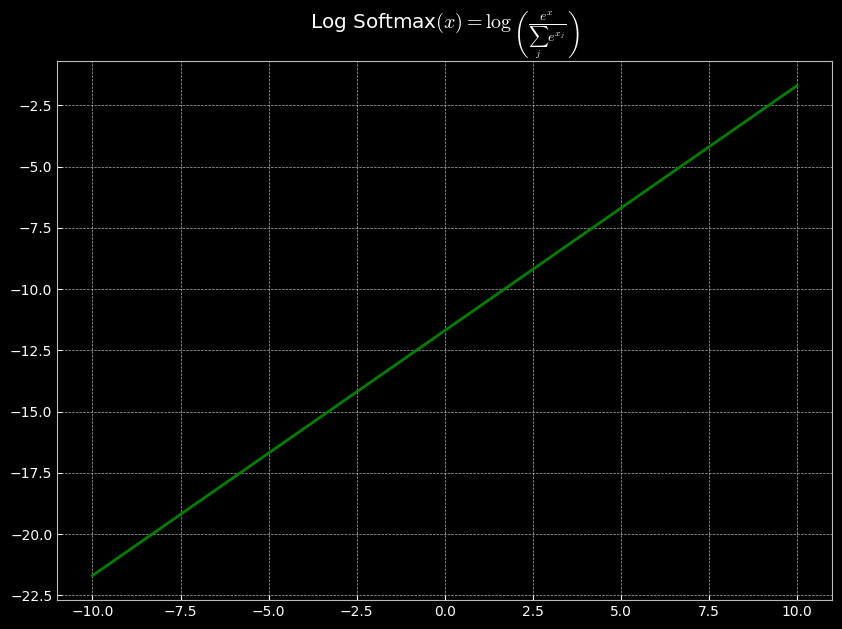

In [55]:
def log_softmax(x):
    return x - np.log(np.sum(np.exp(x)))

fig = plt.figure(figsize=(10,7))
ax = plt.axes()

plt.title(r"Log Softmax$(x) = \log\left(\frac{e^{x}}{\sum_{j}e^{x_j}}\right)$")

xx = np.linspace(-10, 10, 100)
ax.plot(xx, log_softmax(xx), '-g')


In [56]:
# simply define a silu function
def silu(input):
    '''
    Applies the Sigmoid Linear Unit (SiLU) function element-wise:

        SiLU(x) = a * x * sigmoid(x)
    '''
    return input * torch.sigmoid(input) # use torch.sigmoid to make sure that we created the most efficient implemetation based on builtin PyTorch functions

# create a class wrapper from PyTorch nn.Module, so
# the function now can be easily used in models
class SiLU(nn.Module):
    '''
    Applies the Sigmoid Linear Unit (SiLU) function element-wise:
    
        SiLU(x) = x * sigmoid(x)

    Shape:
        - Input: (N, *) where * means, any number of additional
          dimensions
        - Output: (N, *), same shape as the input

    References:
        -  Related paper:
        https://arxiv.org/pdf/1606.08415.pdf

    Examples:
        >>> m = silu()
        >>> input = torch.randn(2)
        >>> output = m(input)

    '''
    def __init__(self):
        '''
        Init method.
        '''
        super().__init__() # init the base class

    def forward(self, input):
        '''
        Forward pass of the function.
        '''
        print("Use SiLU function")
        return silu(input) # simply apply already implemented SiLU

In [57]:
# Create a modified SiLU with a parameter a
class mSiLU(nn.Module):
    '''
    Define a modified Sigmoid Linear Unit (SiLU) function element-wise:
    
        mSiLU(x) = a * x * sigmoid(x)
        
    where a is a scale parameter to control the approximation of SiLU to ReLU.

    Shape:
        - Input: (N, *) where * means, any number of additional
          dimensions
        - Output: (N, *), same shape as the input

    Examples:
        >>> m = mSiLU(2.0)  # with a = 2.0
        >>> input = torch.randn(2)
        >>> output = m(input)

    '''
    def __init__(self, a = 1.0):
        super().__init__()
        self.a = a  # or torch.tensor(a)

    def forward(self, x):
        '''
        Forward pass of the function.
        '''
        print("Input type:", type(x))
        y = self.a * x * torch.sigmoid(x)
        print("y type:", type(y))
        print("y = ",y)
        return y

In [58]:
class mReLU(nn.Module):
# To define a new Class we must include __init__ and forward
# Note: we define h in the init function below
    def __init__(self, h=.5): 
        super(mReLU, self).__init__()
        self.h = h

    def forward(self, x):
        h=self.h
        y = torch.zeros(x.shape)
        z = torch.where(x>h, x, torch.where(x<-h, y, 1/(4*h)*x*x + 1/2*x + 1/4*h))
        return z

'''
import torch.nn.functional as F

class mReLU(nn.Module):
    def __init__(self, h=0.5):
        super(mReLU, self).__init__()
        self.h = h
        self.leaky_relu = nn.LeakyReLU(1 / (4 * h))

    def forward(self, x):
        relu_output = F.relu(x)
        negative_output = -1 * self.leaky_relu(-1 * x)
        return relu_output + negative_output - self.h

'''

'\nimport torch.nn.functional as F\n\nclass mReLU(nn.Module):\n    def __init__(self, h=0.5):\n        super(mReLU, self).__init__()\n        self.h = h\n        self.leaky_relu = nn.LeakyReLU(1 / (4 * h))\n\n    def forward(self, x):\n        relu_output = F.relu(x)\n        negative_output = -1 * self.leaky_relu(-1 * x)\n        return relu_output + negative_output - self.h\n\n'

Text(0, 0.5, 'y')

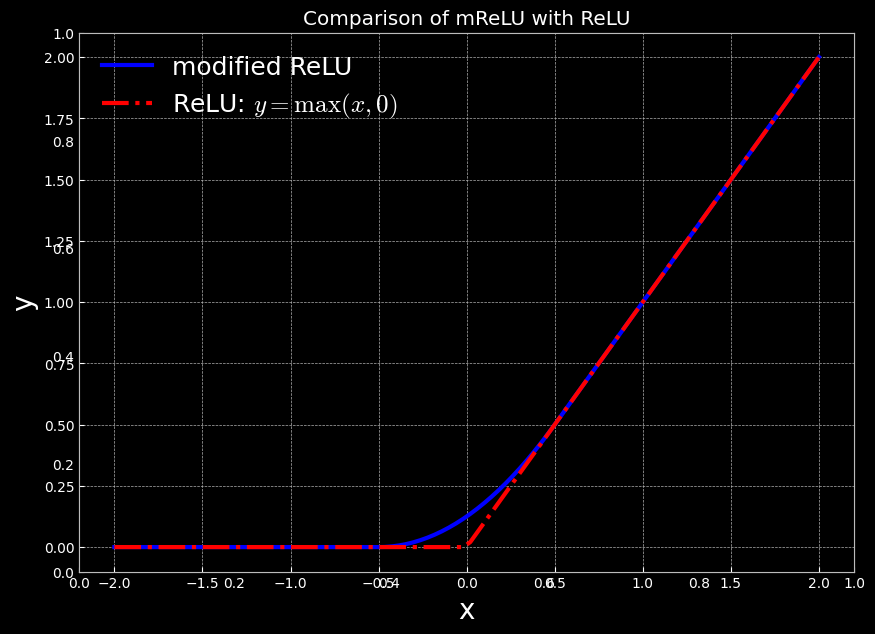

In [59]:
# Plot the function
fig = plt.figure(figsize=(10,7))
ax = plt.axes()

mrelu = mReLU(0.50)
relu = nn.ReLU()

x = torch.linspace(-2, 2, 100)
# Plot the ReLU function
ax = plt.axes()
ax.plot(x, mrelu(x),label = 'modified ReLU', linestyle='-', color='b', linewidth=3)
ax.plot(x, relu(x), label = 'ReLU: $y = \max(x, 0)$', linestyle='-.', color='r', linewidth=3)
plt.legend(loc='upper left',fontsize=18, framealpha=0.0)

plt.title("Comparison of mReLU with ReLU")
plt.xlabel("x", fontsize=20)
plt.ylabel("y", fontsize=20)


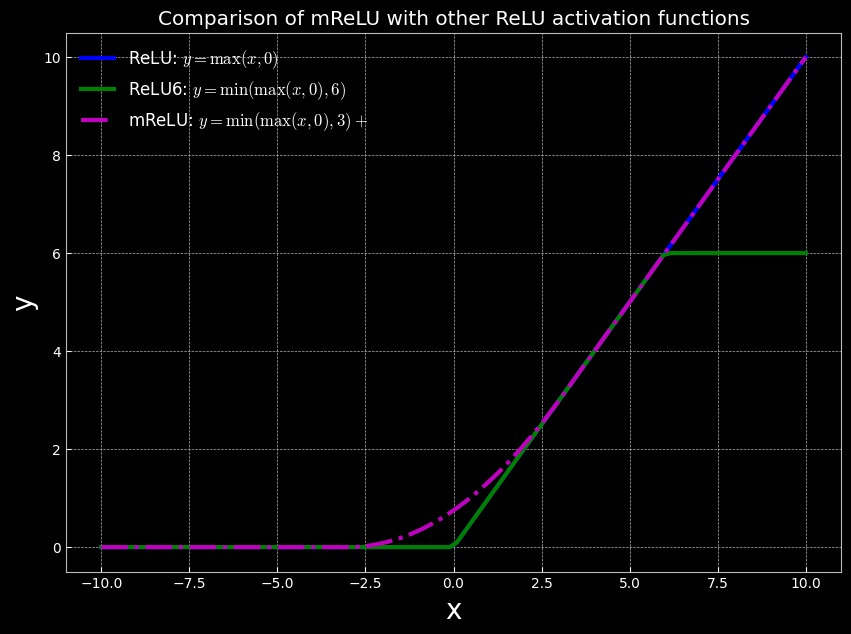

In [61]:
class mReLU(nn.Module):
    def __init__(self, h=0.5):
        super(mReLU, self).__init__()
        self.h = h

    def forward(self, x):
        h = self.h
        y = torch.zeros(x.shape)
        z = torch.where(x > h, x, torch.where(x < -h, y, (1 / (4 * h)) * x * x + (1 / 2) * x + (1 / 4) * h))
        return z

# Define the input tensor
x = torch.linspace(-10, 10, 100)

# Define the activation functions
relu = nn.ReLU()
relu6 = nn.ReLU6()
mrelu = mReLU(h=3.0)

# Compute the output of each activation function for the input tensor
y_relu = relu(x)
y_relu6 = relu6(x)
y_mrelu = mrelu(x)

# Create a plot of the activation functions
fig = plt.figure(figsize=(10, 7))
ax = plt.axes()

plt.title("Comparison of mReLU with other ReLU activation functions")
plt.xlabel("x", fontsize=20)
plt.ylabel("y", fontsize=20)

# Plot the activation functions
ax.plot(x, y_relu, label='ReLU: $y = \max(x, 0)$', linestyle='-', color='b', linewidth=3)
ax.plot(x, y_relu6, label='ReLU6: $y = \min(\max(x, 0), 6)$', linestyle='-', color='g', linewidth=3)
ax.plot(x, y_mrelu, label='mReLU: $y = \min(\max(x, 0), 3) + \frac{1}{12}x^2 + \frac{1}{4}x$', linestyle='-.', color='m', linewidth=3)

# Add a legend to the plot
plt.legend(loc='upper left', fontsize=12, framealpha=0.0)

# Show the plot
plt.show()


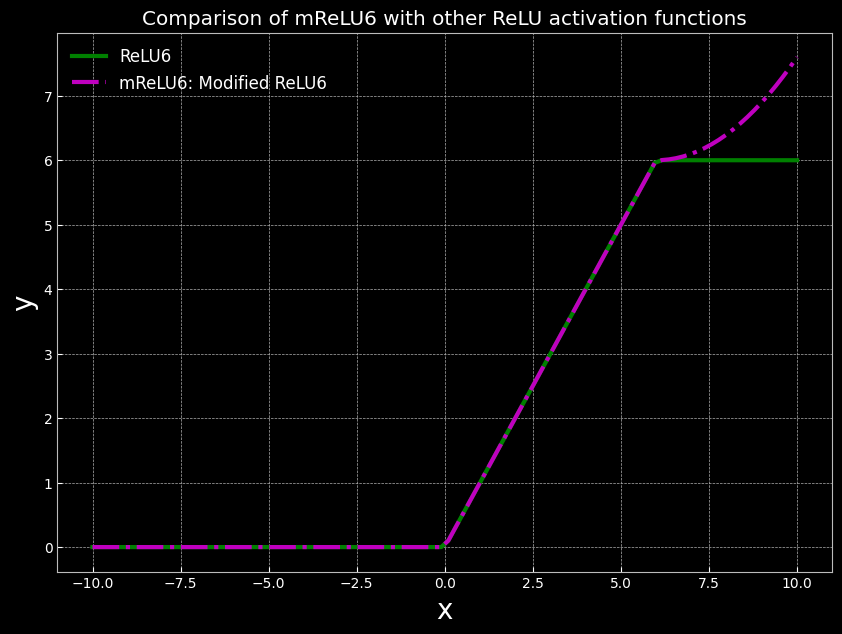

'\ndef mrelu6(x, alpha=0.1, beta=5.0):\n    Applies the modified ReLU 6 function element-wise:\n        mReLU6(x) = min(max(0, x), 6) + alpha * min(max(0, x-6), 6) + beta * min(x, 0)\n    \n    Shape:\n        - Input: (N, *) where * means any number of additional\n          dimensions\n        - Output: (N, *), same shape as the input\n    \n    Arguments:\n        - alpha (float): scaling factor for positive values\n        - beta (float): scaling factor for negative values\n    \n    # First, we apply the regular ReLU function to the input tensor\n    relu_output = F.relu(x)\n    \n    # Then, we apply the three linear functions with different scaling factors to different parts of the input tensor\n    mrelu6_output = relu_output + alpha * torch.clamp(F.relu(x-6), max=6) + beta * F.relu(-x)\n    \n    # Finally, we clamp the output tensor to the range [0,6]\n    mrelu6_output = torch.clamp(mrelu6_output, min=0, max=6)\n    \n    return mrelu6_output\n\n# Plot the function\nfig = plt

In [62]:
def mReLU6(x, gamma=0.1):
    relu6 = nn.ReLU6()
    y = relu6(x)
    return y + gamma * (relu6(x-6)**2)

# Create a class wrapper from PyTorch nn.Module, so
# the function now can be easily used in models.
# Note that this function does not involve any parameter. 

# Define the mReLU6 function
class mReLU6(nn.Module):
    def __init__(self, gamma=0.1):
        super(mReLU6, self).__init__()
        self.gamma = gamma

    def forward(self, x):
        relu6 = nn.ReLU6()
        y = relu6(x)
        return y + self.gamma * (relu6(x-6)**2)

# Plot the function
fig = plt.figure(figsize=(10,7))
ax = plt.axes()

relu6 = nn.ReLU6()
mrelu6 = mReLU6()

x = torch.linspace(-10, 10, 100)

# Plot the activation functions
ax.plot(x, relu6(x), label = 'ReLU6', linestyle='-', color='g', linewidth=3)
ax.plot(x, mrelu6(x), label = 'mReLU6: Modified ReLU6', linestyle='-.', color='m', linewidth=3)
plt.legend(loc='upper left',fontsize=12, framealpha=0.0)

plt.title("Comparison of mReLU6 with other ReLU activation functions")
plt.xlabel("x", fontsize=20)
plt.ylabel("y", fontsize=20)

plt.show()



'''
def mrelu6(x, alpha=0.1, beta=5.0):
    Applies the modified ReLU 6 function element-wise:
        mReLU6(x) = min(max(0, x), 6) + alpha * min(max(0, x-6), 6) + beta * min(x, 0)
    
    Shape:
        - Input: (N, *) where * means any number of additional
          dimensions
        - Output: (N, *), same shape as the input
    
    Arguments:
        - alpha (float): scaling factor for positive values
        - beta (float): scaling factor for negative values
    
    # First, we apply the regular ReLU function to the input tensor
    relu_output = F.relu(x)
    
    # Then, we apply the three linear functions with different scaling factors to different parts of the input tensor
    mrelu6_output = relu_output + alpha * torch.clamp(F.relu(x-6), max=6) + beta * F.relu(-x)
    
    # Finally, we clamp the output tensor to the range [0,6]
    mrelu6_output = torch.clamp(mrelu6_output, min=0, max=6)
    
    return mrelu6_output

# Plot the function
fig = plt.figure(figsize=(10,7))
ax = plt.axes()

plt.title("Comparison of mReLU6 with ReLU6")
plt.xlabel("x", fontsize=20)
plt.ylabel("y", fontsize=20)

# Create activation functions
relu6 = nn.ReLU6()
mrelu6 = mrelu6

x = torch.linspace(-10, 10, 100)

# Plot the activation functions
ax.plot(x, relu6(x), label = 'ReLU6: $y = \min(\max(x, 0), 6)$', linestyle='-', color='g', linewidth=3)
ax.plot(x, mrelu6(x), label = 'mReLU6: $y = \min(\max(x, 0), 6) + 0.1 * \min(\max(x-6, 0), 6) + 5 * \min(x, 0)$', linestyle='-.', color='m', linewidth=3)
plt.legend(loc='upper left',fontsize=12, framealpha=0.0)

'''


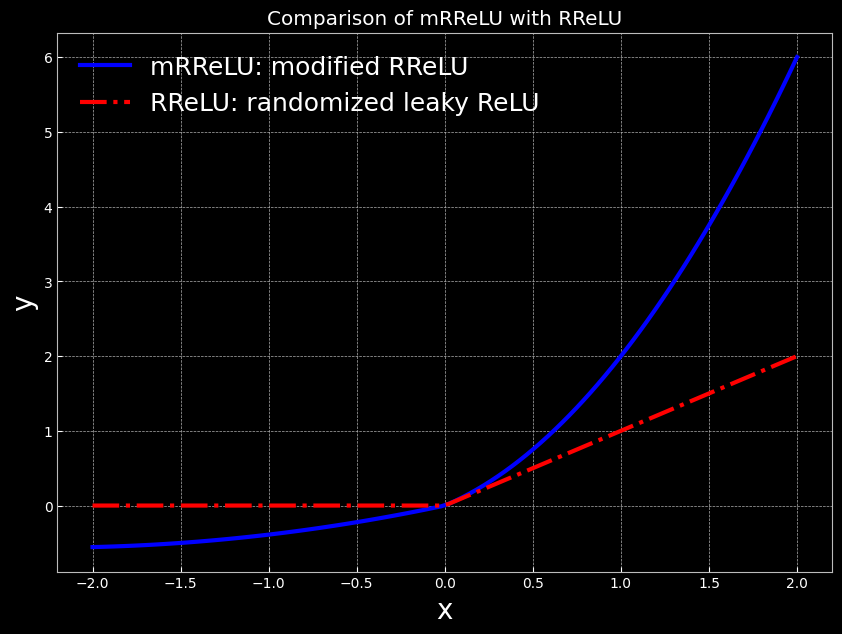

In [63]:
def mRReLU(x, lower=0.125, upper=0.3333):
    l_relu = F.leaky_relu(x, negative_slope=lower)
    u_relu = F.leaky_relu(x, negative_slope=upper)
    return l_relu + u_relu ** 2

# Define the modified RRELU function
class mRReLU(nn.Module):
    def __init__(self, lower=0.125, upper=0.3333):
        super(mRReLU, self).__init__()
        self.lower = lower
        self.upper = upper
        self.l_relu = nn.LeakyReLU(negative_slope=lower)
        self.u_relu = nn.LeakyReLU(negative_slope=upper)
        
    def forward(self, x):
        return self.l_relu(x) + self.u_relu(x)**2

mrelu = mRReLU(0.5)
relu = nn.ReLU()

x = torch.linspace(-2, 2, 100)
fig = plt.figure(figsize=(10,7))
# Plot the activation functions
plt.plot(x, mrelu(x), label = 'mRReLU: modified RReLU', linestyle='-', color='b', linewidth=3)
plt.plot(x, relu(x), label = 'RReLU: randomized leaky ReLU', linestyle='-.', color='r', linewidth=3)

plt.legend(loc='upper left',fontsize=18, framealpha=0.0)

plt.title("Comparison of mRReLU with RReLU")
plt.xlabel("x", fontsize=20)
plt.ylabel("y", fontsize=20)

plt.show()


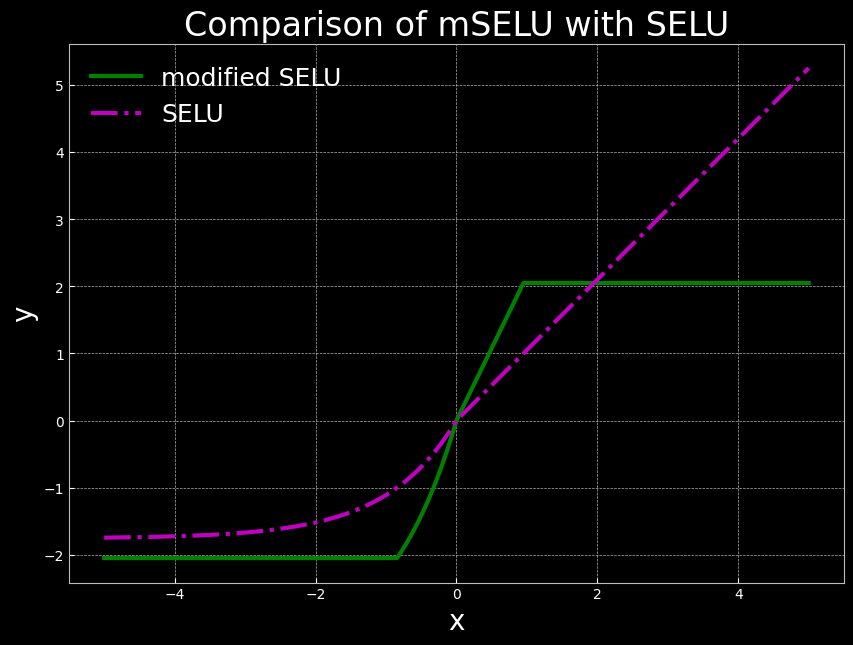

'\n# Define the x values to plot\nx = torch.linspace(-5, 5, 100)\n\n# Instantiate the mSELU and SELU activations\nmse = mSELU()\nselu = nn.SELU()\n\n# Compute the output of the activations for each x value\ny_mse = mse(x).detach().numpy()\ny_selu = selu(x).detach().numpy()\n\n# Plot the functions\nplt.plot(x, y_mse, label=\'mSELU\', linestyle=\'-\', color=\'g\', linewidth=3)\nplt.plot(x, y_selu, label=\'SELU\', linestyle=\'-.\', color=\'m\', linewidth=3)\n\n# Add a legend and labels\nplt.legend(loc=\'upper left\', fontsize=18, framealpha=0.0)\nplt.title("Comparison of mSELU with SELU")\nplt.xlabel("x", fontsize=20)\nplt.ylabel("y", fontsize=20)\n\n# Show the plot\nplt.show()\n'

In [64]:
def mselu(x, lower=-1, upper=1):
    alpha = 1.67326
    scale = 1.0507
    
    # Compute the standard SELU activation
    selu = torch.nn.functional.selu(x, alpha=alpha, scale=scale)
    
    # Compute the modified part of the activation function
    mask = (selu < lower) | (selu > upper)
    mask = mask.float()
    mod = scale * (lower * (alpha * torch.exp(selu) - alpha) * mask
                  + selu * (1 - mask))
    
    # Add the modified component to the standard SELU activation
    y = selu + mod
    
    return y

# Define the modified SELU function
class mSELU(nn.Module):
    def __init__(self, lower=-1, upper=1):
        super(mSELU, self).__init__()
        self.lower = lower
        self.upper = upper
        self.alpha = 1.67326
        self.scale = 1.0507

    def forward(self, x):
        # Compute the standard SELU activation
        std_selu = torch.where(x > 0, self.scale * x, self.scale * (self.alpha * (torch.exp(x) - 1)))
        std_selu = torch.where(std_selu < self.lower, self.lower * torch.ones_like(std_selu), std_selu)
        std_selu = torch.where(std_selu > self.upper, self.upper * torch.ones_like(std_selu), std_selu)

        # Compute the modified part of the activation function
        mod = self.scale * (self.lower * (self.alpha * torch.exp(std_selu) - self.alpha) * (std_selu < self.lower).float() + std_selu * (std_selu >= self.lower).float() * (std_selu <= self.upper).float() + self.upper * (std_selu > self.upper).float())

        # Combine the standard and modified parts
        y = std_selu + mod
        return y


# Generate data for plotting
x = torch.linspace(-5, 5, 1000)
selu_y = torch.nn.functional.selu(x).detach().numpy()
mSelu_y = mSELU()(x).detach().numpy()

# Plot the functions
fig = plt.figure(figsize=(10,7))
ax = plt.axes()
ax.plot(x, mSelu_y, label='modified SELU', linestyle='-', color='g', linewidth=3)
ax.plot(x, selu_y, label='SELU', linestyle='-.', color='m', linewidth=3)
plt.legend(loc='upper left', fontsize=18, framealpha=0.0)
plt.xlabel('x', fontsize=20)
plt.ylabel('y', fontsize=20)
plt.title('Comparison of mSELU with SELU', fontsize=24)
plt.show()


'''
# Define the x values to plot
x = torch.linspace(-5, 5, 100)

# Instantiate the mSELU and SELU activations
mse = mSELU()
selu = nn.SELU()

# Compute the output of the activations for each x value
y_mse = mse(x).detach().numpy()
y_selu = selu(x).detach().numpy()

# Plot the functions
plt.plot(x, y_mse, label='mSELU', linestyle='-', color='g', linewidth=3)
plt.plot(x, y_selu, label='SELU', linestyle='-.', color='m', linewidth=3)

# Add a legend and labels
plt.legend(loc='upper left', fontsize=18, framealpha=0.0)
plt.title("Comparison of mSELU with SELU")
plt.xlabel("x", fontsize=20)
plt.ylabel("y", fontsize=20)

# Show the plot
plt.show()
'''

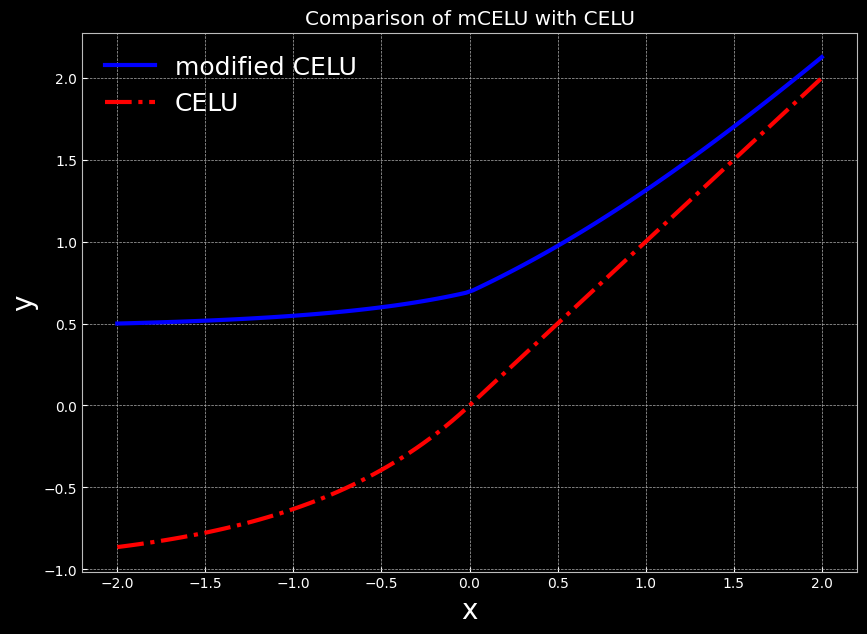

'\n    def __init__(self, lower=0.1, upper=1.0, alpha=1.0):\n        super(mCELU, self).__init__()\n        self.lower = lower\n        self.upper = upper\n        self.alpha = alpha\n        self.relu = nn.ReLU()\n        self.sigmoid = nn.Sigmoid()\n        \n        # Initialize the weight and bias for the affine transformation\n        self.weight = nn.Parameter(torch.Tensor(1))\n        self.bias = nn.Parameter(torch.Tensor(1))\n        self.reset_parameters()\n        \n    def reset_parameters(self):\n        nn.init.ones_(self.weight)\n        nn.init.zeros_(self.bias)\n        \n    def forward(self, x):\n        # Compute the standard CELU activation\n        celu = F.celu(x, alpha=self.alpha)\n        \n        # Apply the mRReLU modification\n        mrrelu = mRReLU(lower=self.lower, upper=self.upper)\n        y = self.weight * mrrelu(self.sigmoid(celu)) + self.bias\n        return y\n\n# Define the activation functions\nmcelu = mCELU(lower=0.1, upper=1.0, alpha=1.0)\ncelu 

In [65]:
def mCELU(x, alpha):
    # apply modified ELU function
    elu_x = F.elu(x, alpha=alpha)
    # apply Softplus function
    softplus_x = F.softplus(elu_x)
    return softplus_x

class mCELU(nn.Module):
    def __init__(self, alpha):
        super(mCELU, self).__init__()
        self.alpha = alpha
    
    def forward(self, x):
        # apply modified ELU function
        elu_x = F.elu(x, alpha=self.alpha)
        # apply Softplus function
        softplus_x = F.softplus(elu_x)
        return softplus_x

# Define the activation functions
mcelu = mCELU(alpha=0.5)
celu = nn.CELU(alpha=1.0)

# Generate the x values for the plot
x = torch.linspace(-2, 2, 100)

# Evaluate the activation functions at the x values
mcelu_y = mcelu(x)
celu_y = celu(x)

# Plot the activation functions
fig = plt.figure(figsize=(10,7))
ax = plt.axes()
ax.plot(x.numpy(), mcelu_y.detach().numpy(), label='modified CELU', linestyle='-', color='b', linewidth=3)
ax.plot(x.numpy(), celu_y.detach().numpy(), label='CELU', linestyle='-.', color='r', linewidth=3)
plt.legend(loc='upper left', fontsize=18, framealpha=0.0)
plt.title("Comparison of mCELU with CELU")
plt.xlabel("x", fontsize=20)
plt.ylabel("y", fontsize=20)

# Show the plot
plt.show()


'''
    def __init__(self, lower=0.1, upper=1.0, alpha=1.0):
        super(mCELU, self).__init__()
        self.lower = lower
        self.upper = upper
        self.alpha = alpha
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
        # Initialize the weight and bias for the affine transformation
        self.weight = nn.Parameter(torch.Tensor(1))
        self.bias = nn.Parameter(torch.Tensor(1))
        self.reset_parameters()
        
    def reset_parameters(self):
        nn.init.ones_(self.weight)
        nn.init.zeros_(self.bias)
        
    def forward(self, x):
        # Compute the standard CELU activation
        celu = F.celu(x, alpha=self.alpha)
        
        # Apply the mRReLU modification
        mrrelu = mRReLU(lower=self.lower, upper=self.upper)
        y = self.weight * mrrelu(self.sigmoid(celu)) + self.bias
        return y

# Define the activation functions
mcelu = mCELU(lower=0.1, upper=1.0, alpha=1.0)
celu = nn.CELU(alpha=1.0)

# Generate the x values for the plot
x = torch.linspace(-3, 3, 100)

# Evaluate the activation functions at the x values
mcelu_y = mcelu(x).detach().numpy()
celu_y = celu(x)

# Plot the activation functions
fig = plt.figure(figsize=(10,7))
ax = plt.axes()
ax.plot(x, mcelu_y, label='modified CELU', linestyle='-', color='b', linewidth=3)
ax.plot(x, celu_y, label='CELU', linestyle='-.', color='r', linewidth=3)
plt.legend(loc='upper left', fontsize=18, framealpha=0.0)
plt.title("Comparison of mCELU with CELU")
plt.xlabel("x", fontsize=20)
plt.ylabel("y", fontsize=20)

# Show the plot
plt.show()
'''


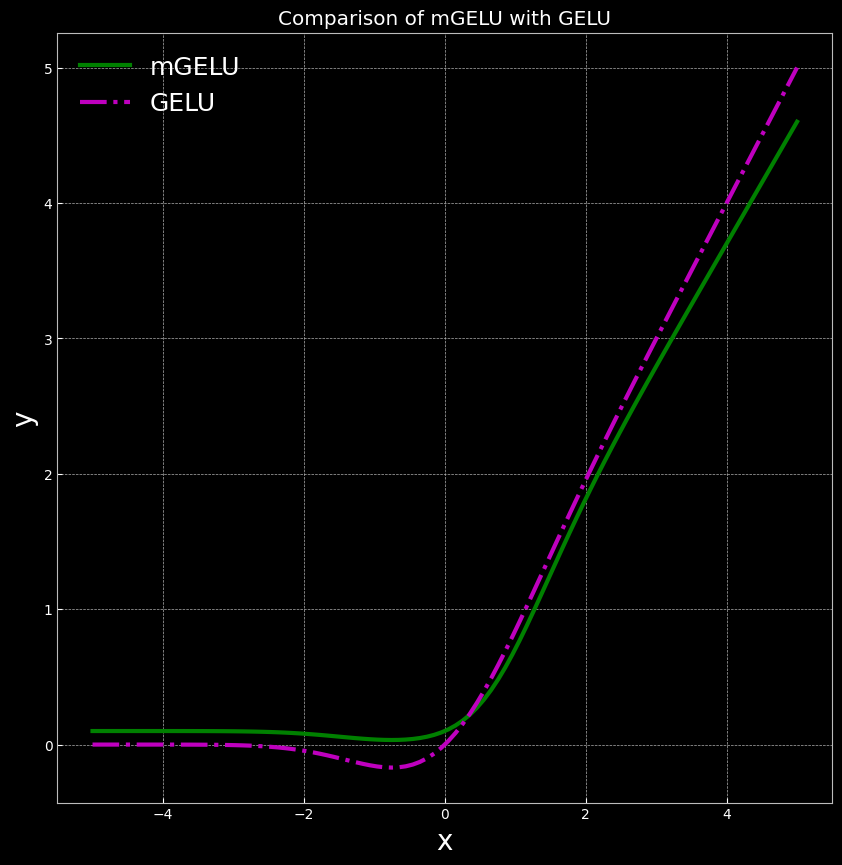

In [66]:
def mGELU(x, lower=0.1, upper=1.0):
    # Compute the standard GELU activation
    gelu = F.gelu(x)

    # Compute the mGELU modification
    norm_cdf = 0.5 * (1 + torch.erf(gelu / torch.sqrt(torch.tensor(2.0))))

    y = lower + (upper - lower) * norm_cdf * gelu
    return y

class mGELU(nn.Module):
    def __init__(self, lower=0.1, upper=1.0):
        super(mGELU, self).__init__()
        self.lower = lower
        self.upper = upper
        
    def forward(self, x):
        # Compute the standard GELU activation
        gelu = F.gelu(x)
        
        # Compute the mGELU modification
        norm_cdf = 0.5 * (1 + torch.erf(gelu / torch.sqrt(torch.tensor(2.0))))

        y = self.lower + (self.upper - self.lower) * norm_cdf * gelu
        return y

# Define the x values to plot
x = torch.linspace(-5, 5, 100)

# Instantiate the mGELU and GELU activations
mgelu = mGELU()
gelu = nn.GELU()

# Compute the output of the activations for each x value
y_mgelu = mgelu(x).detach().numpy()
y_gelu = gelu(x).detach().numpy()

# Plot the functions
plt.plot(x, y_mgelu, label='mGELU', linestyle='-', color='g', linewidth=3)
plt.plot(x, y_gelu, label='GELU', linestyle='-.', color='m', linewidth=3)

# Add a legend and labels
plt.legend(loc='upper left', fontsize=18, framealpha=0.0)
plt.title("Comparison of mGELU with GELU")
plt.xlabel("x", fontsize=20)
plt.ylabel("y", fontsize=20)

# Show the plot
plt.show()



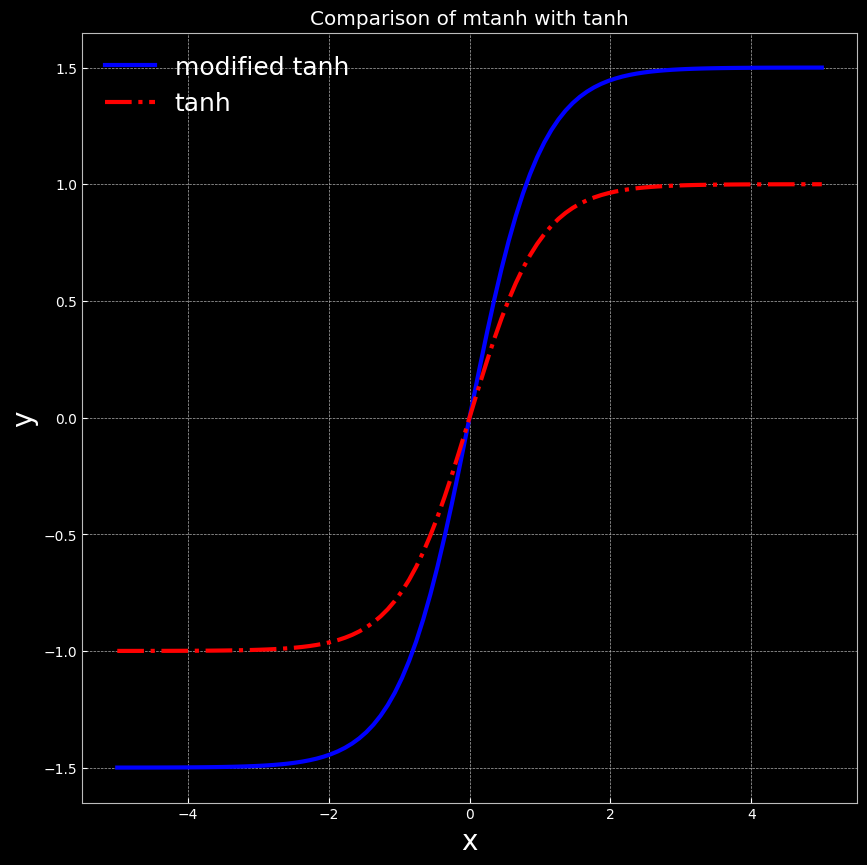

In [67]:
def mtanh(x, lower=1.5, upper=1.0):
  return lower * torch.tanh(upper * x)

class mtanh(nn.Module):
    def __init__(self, lower=1.5, upper=1.0):
        super(mtanh, self).__init__()
        self.lower = lower
        self.upper = upper

    def forward(self, x):
        y = self.lower * torch.tanh(self.upper * x)
        return y

# Define the x values to plot
x = torch.linspace(-5, 5, 100)

# Instantiate the mtanh and tanh activations
mt = mtanh()
t = nn.Tanh()

# Compute the output of the activations for each x value
y_mt = mt(x).detach().numpy()
y_t = t(x).detach().numpy()

# Plot the functions
plt.plot(x, y_mt, label='modified tanh', linestyle='-', color='b', linewidth=3)
plt.plot(x, y_t, label='tanh', linestyle='-.', color='r', linewidth=3)

# Add a legend and labels
plt.legend(loc='upper left', fontsize=18, framealpha=0.0)
plt.title("Comparison of mtanh with tanh")
plt.xlabel("x", fontsize=20)
plt.ylabel("y", fontsize=20)

# Show the plot
plt.show()


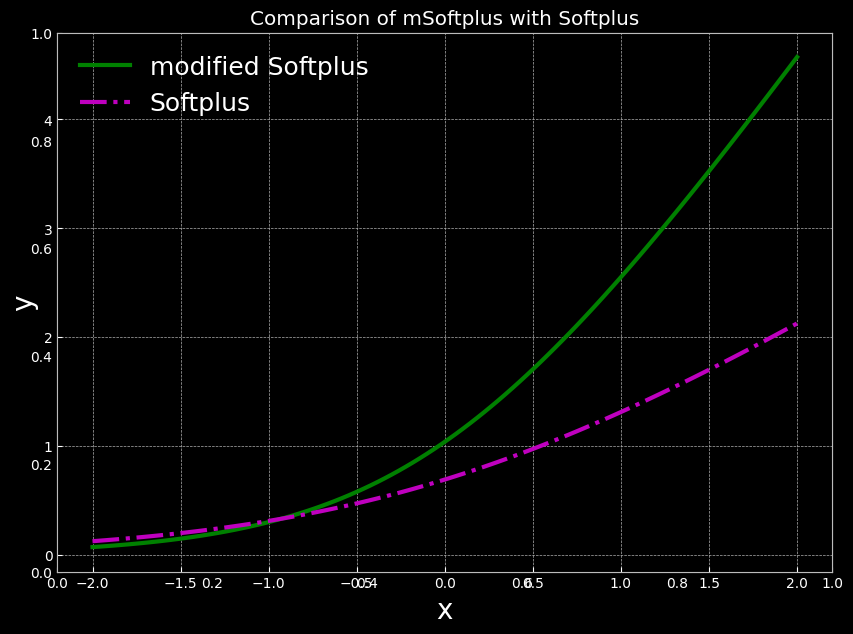

In [68]:
def mSoftplus(x, a=1.5, b=1.5):
  return a * F.softplus(b * x)

class mSoftplus(nn.Module):
    def __init__(self, a=1.5, b=1.5):
        super(mSoftplus, self).__init__()
        self.a = a
        self.b = b

    def forward(self, x):
        y = self.a * torch.log(1 + torch.exp(self.b * x))
        return y

# Plot the function
fig = plt.figure(figsize=(10,7))
ax = plt.axes()

msoftplus = mSoftplus(a=1.5, b=1.5)
softplus = nn.Softplus()

x = torch.linspace(-2, 2, 100)
# Plot the Softplus function
ax = plt.axes()
ax.plot(x, msoftplus(x),label = 'modified Softplus', linestyle='-', color='g', linewidth=3)
ax.plot(x, softplus(x), label = 'Softplus', linestyle='-.', color='m', linewidth=3)
plt.legend(loc='upper left',fontsize=18, framealpha=0.0)

plt.title("Comparison of mSoftplus with Softplus")
plt.xlabel("x", fontsize=20)
plt.ylabel("y", fontsize=20)

# Show the plot
plt.show()


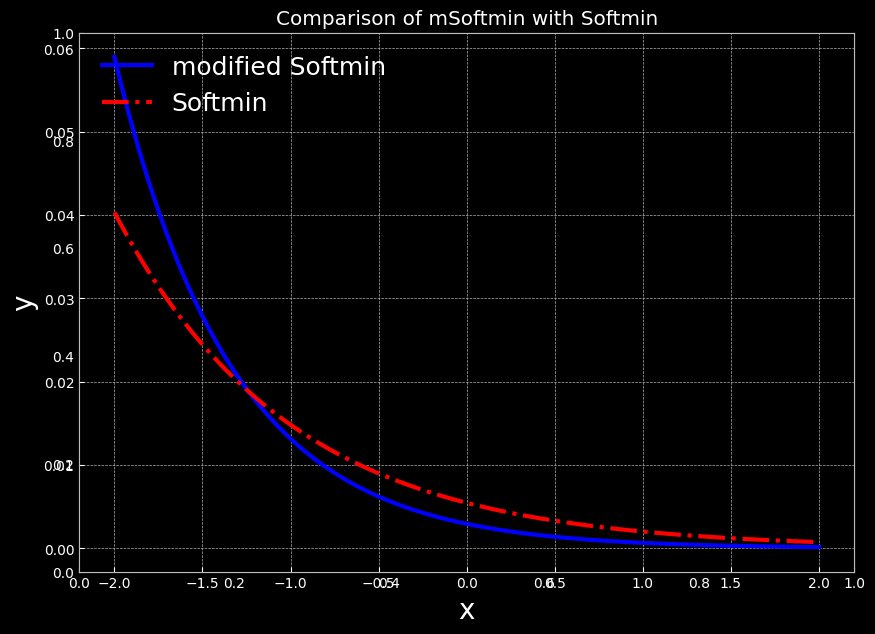

In [69]:
def mSOFTMIN(x, a=1.5):
    y = torch.exp(-a * x)
    z = torch.sum(y, dim=-1, keepdim=True)
    out = y / z
    return out
    
class mSOFTMIN(nn.Module):
    def __init__(self, a=1.5):
        super(mSOFTMIN, self).__init__()
        self.a = a
        
    def forward(self, x):
        y = torch.exp(-self.a * x)
        z = torch.sum(y, dim=-1, keepdim=True)
        out = y / z
        return out

# Plot the function
fig = plt.figure(figsize=(10,7))
ax = plt.axes()

msoftmin = mSOFTMIN(a=1.5)
softmin = nn.Softmin(dim=-1)

x = torch.linspace(-2, 2, 100)
# Plot the Softmin function
ax = plt.axes()
ax.plot(x, msoftmin(x), label='modified Softmin', linestyle='-', color='b', linewidth=3)
ax.plot(x, softmin(x), label='Softmin', linestyle='-.', color='r', linewidth=3)
plt.legend(loc='upper left', fontsize=18, framealpha=0.0)

plt.title("Comparison of mSoftmin with Softmin")
plt.xlabel("x", fontsize=20)
plt.ylabel("y", fontsize=20)

# Show the plot
plt.show()


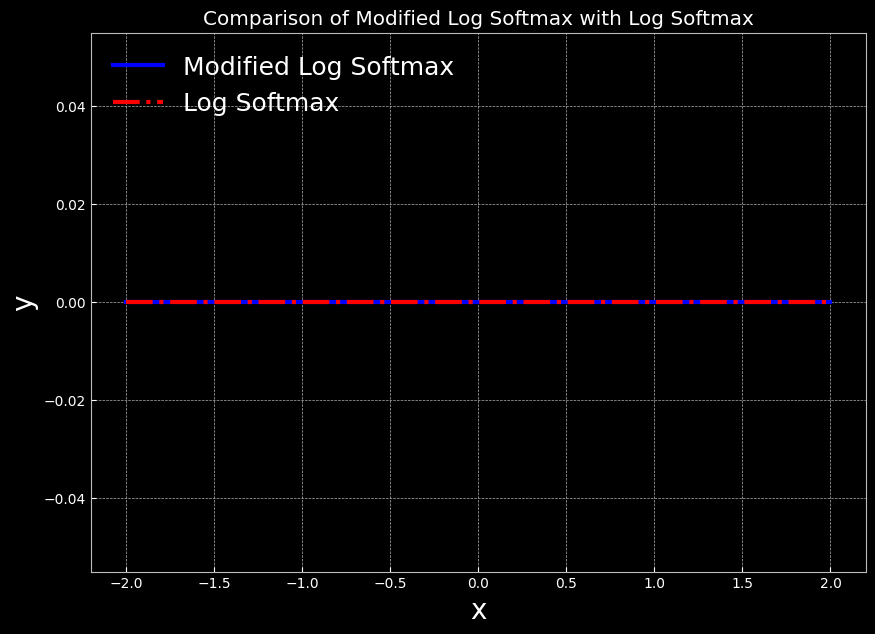

In [70]:
def mLogSoftmax(x, alpha):
    # Apply the modified Log function
    log_x = torch.log(torch.abs(x) + alpha)
    # Apply the Softmax function
    softmax_x = F.softmax(log_x, dim=1)
    # Apply the Log function
    log_softmax_x = torch.log(softmax_x + 1e-10)
    return log_softmax_x
    
# Define the modified log softmax activation function
class ModifiedLogSoftmax(torch.nn.Module):
    def __init__(self, alpha):
        super().__init__()
        self.alpha = alpha
    
    def forward(self, x):
        # Apply the modified Log function
        log_x = torch.log(torch.abs(x) + self.alpha)
        # Apply the Softmax function
        softmax_x = F.softmax(log_x, dim=1)
        # Apply the Log function
        log_softmax_x = torch.log(softmax_x + 1e-10)
        return log_softmax_x

# Define the LogSoftmax activation function
log_softmax = torch.nn.LogSoftmax(dim=1)

# Generate the x values for the plot
x = torch.linspace(-2, 2, 100)

# Evaluate the activation functions at the x values
modified_log_softmax_y = ModifiedLogSoftmax(alpha=0.5)(x.unsqueeze(1)).squeeze(1)
log_softmax_y = log_softmax(x.unsqueeze(1)).squeeze(1)

# Plot the activation functions
fig = plt.figure(figsize=(10,7))
ax = plt.axes()
ax.plot(x.numpy(), modified_log_softmax_y.detach().numpy(), label='Modified Log Softmax', linestyle='-', color='b', linewidth=3)
ax.plot(x.numpy(), log_softmax_y.detach().numpy(), label='Log Softmax', linestyle='-.', color='r', linewidth=3)
plt.legend(loc='upper left', fontsize=18, framealpha=0.0)
plt.title("Comparison of Modified Log Softmax with Log Softmax")
plt.xlabel("x", fontsize=20)
plt.ylabel("y", fontsize=20)

# Show the plot
plt.show()



### Test results

- Use SiLU:

[EPOCH]: 16, [LOSS]: 0.109319, [ACCURACY]: 0.967

Training the nonlinear model takes 0.0360 seconds

- Use mSiLU(a) with a = 2.0

[EPOCH]: 12, [LOSS]: 0.176474, [ACCURACY]: 0.963
Training the nonlinear model takes 0.0348 seconds

In [84]:
activation_functions = [
    mRReLU(0.1, 0.5),
    mtanh(),
    mSELU(1.67326, 1.0507),
    mCELU(1.0),
    mGELU(),
    mSoftplus(1.0),
    mSOFTMIN(),
    SiLU(),
    mSiLU(5.0),
    mReLU6(0.2),
    mtanh(2.0, 0.5)
]

table1_results = []

for activation_function in activation_functions:
    model = nn.Sequential(
        nn.Linear(D, H1),
        activation_function,
        nn.Linear(H1, H2),
        activation_function,
        nn.Linear(H2, H3),
        activation_function,
        nn.Linear(H3, C)
    )
    model.to(device)

    # nn package also has different loss functions.
    # we use cross entropy loss for our classification task
    Loss = torch.nn.CrossEntropyLoss()

    # we use the optim package to apply
    # ADAM for our parameter updates
    learning_rate = 0.1
    lambda_l2 = 1e-5
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

    # e = 1.  # plotting purpose

    # Training
    eps = 0.95
    IteMax = 500
    length4y = len(y)
    acc = 0.0
    ite = 0
    last_epoch_loss = None
    last_epoch_accuracy = None

    while acc < eps and ite < IteMax:

        # Get the predicted value y_pred of the target function value y at the input data X
        y_pred = model(X)

        # Compute the loss and accuracy
        loss = Loss(y_pred, y)
        score, predicted = torch.max(y_pred, 1)
        acc = (y == predicted).sum().float() / len(y)

        # Save the loss and accuracy of the last epoch
        if ite == IteMax-1:
            last_epoch_loss = loss.item()
            last_epoch_accuracy = acc

        # zero the gradients before running
        # the backward pass.
        optimizer.zero_grad()

        # Calculate the gradient vector of the loss function with respect to parameters w
        #  by loss.backward()
        loss.backward()

        # Update the parameters w by the grandient descent method
        #  w = w + lr * gradient
        optimizer.step()
        # Increase the number of iteration by 1
        ite += 1

    # Add the results for this activation function to the table1_results list
    table1_results.append((type(activation_function).__name__, last_epoch_loss, last_epoch_accuracy))

for result in table1_results:
    if result[1] is not None and result[2] is not None:
        print(f"{result[0]}\t{result[1]:.6f}\t{result[2]:.3f}")
    else:
        print(f"{result[0]}\tN/A\tN/A")




Use SiLU function
Use SiLU function
Use SiLU function
Use SiLU function
Use SiLU function
Use SiLU function
Use SiLU function
Use SiLU function
Use SiLU function
Use SiLU function
Use SiLU function
Use SiLU function
Use SiLU function
Use SiLU function
Use SiLU function
Use SiLU function
Use SiLU function
Use SiLU function
Use SiLU function
Use SiLU function
Use SiLU function
Use SiLU function
Use SiLU function
Use SiLU function
Use SiLU function
Use SiLU function
Use SiLU function
Use SiLU function
Use SiLU function
Use SiLU function
Use SiLU function
Use SiLU function
Use SiLU function
Use SiLU function
Use SiLU function
Use SiLU function
Use SiLU function
Use SiLU function
Use SiLU function
Use SiLU function
Use SiLU function
Use SiLU function
Use SiLU function
Use SiLU function
Use SiLU function
Use SiLU function
Use SiLU function
Use SiLU function
Use SiLU function
Use SiLU function
Use SiLU function
Use SiLU function
Use SiLU function
Use SiLU function
Use SiLU function
Use SiLU f

In [71]:
from torch.nn.modules.activation import Sigmoid
# nn package to create our linear model
# each Linear module has a weight and bias
# Note: Increasing the number of hidden layers can make the predicted function become more nonlinear
#       so that the prediction accuracy can be further improved. 
#activation_function = mRReLU()
#activation_function = mtanh()
#activation_function = mSELU()
#activation_function = mCELU()
#activation_function = mGELU()
#activation_function = Sigmoid()
#activation_function = mSoftplus()
#activation_function = mSOFTMIN()
#activation_function = mLogSoftmax()
#activation_function = SiLU()
#activation_function = mSiLU(5.0)
activation_function = mReLU6(0.2)
#activation_function = mtanh(2.0, 0.5)

N = 500  # number of sample points in each subdomain D_i
D = 2  # dimensions
C = 3  # number of sub-classes
H1 = 20  # number of neuros of the first hidden layer
H2 = 10  # number of neuros of the second hidden layer
H3 = 10  # number of neuros of the third hidden layer

model = nn.Sequential(
    nn.Linear(D, H1),
    activation_function,
    nn.Linear(H1, H2),
    activation_function,
    nn.Linear(H2, H3),
    activation_function,
    nn.Linear(H3, C)
)
model.to(device)

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
Loss = torch.nn.CrossEntropyLoss()

# we use the optim package to apply
# ADAM for our parameter updates
learning_rate = 0.1
lambda_l2 = 1e-5
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,  weight_decay=lambda_l2) 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# e = 1.  # plotting purpose

# Training
eps = 0.95
IteMax = 500
length4y = len(y)
acc = 0.0
ite = 0

# Start the timer by perf_counter(), which measures the time in seconds from this moment 
tic = time.perf_counter()

while acc < eps and ite < IteMax:
    
    # Get the predicted value y_pred of the target function value y at the input data X
    y_pred = model(X)
    
    # Compute the loss and accuracy
    loss = Loss(y_pred, y)
    score, predicted = torch.max(y_pred, 1)
    acc = (y == predicted).sum().float() / len(y)
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (ite, loss.item(), acc))
    #display.clear_output(wait=True)
    
    # zero the gradients before running
    # the backward pass.
    optimizer.zero_grad()
    
    # Calculate the gradient vector of the loss function with respect to parameters w
    #  by loss.backward()
    loss.backward()
    
    # Update the parameters w by the grandient descent method
    #  w = w + lr * gradient
    optimizer.step()
    # Increase the number of iteration by 1
    ite += 1

# Set another time counter
toc = time.perf_counter()
# Time cost between tic and toc is toc - tic
print(f"Training the nonlinear model takes {toc - tic:0.4f} seconds")

'''
# nn package to create our linear model
# each Linear module has a weight and bias
# Note: Increasing the number of hidden layers can make the predicted function become more nonlinear
#       so that the prediction accuracy can be further improved. 
#activation_function = nn.ReLU()
#activation_function = SiLU()
#activation_function = mSiLU(5.0)
activation_function = nn.LeakyReLU()

N = 1000  # number of sample points in each subdomain D_i
D = 2  # dimensions
C = 3  # number of sub-classes
H1 = 50  # number of neuros of the first hidden layer
H2 = 30  # number of neuros of the second hidden layer
H3 = 10  # number of neuros of the third hidden layer
H4 = 10  # number of neuros of the fourth hidden layer

model = nn.Sequential(
    nn.Linear(D, H1),
    activation_function,
    nn.Linear(H1, H2),
    activation_function,
    nn.Linear(H2, H3),
    activation_function,
    nn.Linear(H3, H4),
    activation_function,
    nn.Linear(H4, C)
)
model.to(device)

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
Loss = torch.nn.CrossEntropyLoss()

# we use the optim package to apply
# ADAM for our parameter updates
learning_rate = 0.01
lambda_l2 = 1e-4
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,  weight_decay=lambda_l2) 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# e = 1.  # plotting purpose

# Training
eps = 0.95
IteMax = 1000
length4y = len(y)
acc = 0.0
ite = 0

# Start the timer by perf_counter(), which measures the time in seconds from this moment 
tic = time.perf_counter()

while acc < eps and ite < IteMax:
    
    # Get the predicted value y_pred of the target function value y at the input data X
    y_pred = model(X)
    
    # Compute the loss and accuracy
    loss = Loss(y_pred, y)
    score, predicted = torch.max(y_pred, 1)
    acc = (y == predicted).sum().float() / len(y)
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (ite, loss.item(), acc))
    #display.clear_output(wait=True)
    
    # zero the gradients before running
    # the backward pass.
    optimizer.zero_grad()
    
    # Calculate the gradient vector of the loss function with respect to parameters w
    #  by loss.backward()
    loss.backward()
    
    # Update the parameters w by the grandient descent method
    #  w = w + lr * gradient
    optimizer.step()
    # Increase the number of iteration by 1
    ite += 1

# Set another time counter
toc = time.perf_counter()
# Time cost between tic and toc is toc - tic
print(f"Training the nonlinear model takes {toc - tic:0.4f} seconds")
'''

'''
# nn package to create our linear model
# each Linear module has a weight and bias
# Note: Increasing the number of hidden layers can make the predicted function become more nonlinear
#       so that the prediction accuracy can be further improved. 
#activation_function = nn.ReLU()
#activation_function = SiLU()
#activation_function = mSiLU(5.0)
activation_function = nn.LeakyReLU()

N = 1000  # number of sample points in each subdomain D_i
D = 2  # dimensions
C = 3  # number of sub-classes
H1 = 50  # number of neuros of the first hidden layer
H2 = 30  # number of neuros of the second hidden layer
H3 = 10  # number of neuros of the third hidden layer
H4 = 10  # number of neuros of the fourth hidden layer

model = nn.Sequential(
    nn.Linear(D, H1),
    activation_function,
    nn.Linear(H1, H2),
    activation_function,
    nn.Linear(H2, H3),
    activation_function,
    nn.Linear(H3, H4),
    activation_function,
    nn.Linear(H4, C)
)
model.to(device)

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
Loss = torch.nn.CrossEntropyLoss()

# we use the optim package to apply
# Adagrad for our parameter updates
learning_rate = 0.01
lambda_l2 = 1e-4
optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate, weight_decay=lambda_l2)

# e = 1.  # plotting purpose

# Training
eps = 0.95
IteMax = 1000
length4y = len(y)
acc = 0.0
ite = 0

# Start the timer by perf_counter(), which measures the time in seconds from this moment 
tic = time.perf_counter()

while acc < eps and ite < IteMax:
    
    # Get the predicted value y_pred of the target function value y at the input data X
    y_pred = model(X)
    
    # Compute the loss and accuracy
    loss = Loss(y_pred, y)
    score, predicted = torch.max(y_pred, 1)
    acc = (y == predicted).sum().float() / len(y)
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (ite, loss.item(), acc))
    #display.clear_output(wait=True)
    
    # zero the gradients before running
    # the backward pass.
    optimizer.zero_grad()
    
    # Calculate the gradient vector of the loss function with respect to parameters w
    #  by loss.backward()
    loss.backward()
    
    # Update the parameters w by the grandient descent method
    #  w = w + lr * gradient
    optimizer.step()
    # Increase the number of iteration by 1
    ite += 1

# Set another time counter
toc = time.perf_counter()
# Time cost between tic and toc is toc - tic
print(f"Training the nonlinear model takes {toc - tic:0.4f} seconds")

'''

[EPOCH]: 0, [LOSS]: 1.105758, [ACCURACY]: 0.333
[EPOCH]: 1, [LOSS]: 1.081309, [ACCURACY]: 0.346
[EPOCH]: 2, [LOSS]: 1.006027, [ACCURACY]: 0.547
[EPOCH]: 3, [LOSS]: 0.877268, [ACCURACY]: 0.687
[EPOCH]: 4, [LOSS]: 0.710194, [ACCURACY]: 0.692
[EPOCH]: 5, [LOSS]: 0.644204, [ACCURACY]: 0.735
[EPOCH]: 6, [LOSS]: 0.651184, [ACCURACY]: 0.759
[EPOCH]: 7, [LOSS]: 0.470008, [ACCURACY]: 0.777
[EPOCH]: 8, [LOSS]: 0.513576, [ACCURACY]: 0.837
[EPOCH]: 9, [LOSS]: 0.347510, [ACCURACY]: 0.857
[EPOCH]: 10, [LOSS]: 0.427071, [ACCURACY]: 0.829
[EPOCH]: 11, [LOSS]: 0.368982, [ACCURACY]: 0.866
[EPOCH]: 12, [LOSS]: 0.347347, [ACCURACY]: 0.874
[EPOCH]: 13, [LOSS]: 0.367590, [ACCURACY]: 0.857
[EPOCH]: 14, [LOSS]: 0.299521, [ACCURACY]: 0.894
[EPOCH]: 15, [LOSS]: 0.262454, [ACCURACY]: 0.913
[EPOCH]: 16, [LOSS]: 0.264443, [ACCURACY]: 0.896
[EPOCH]: 17, [LOSS]: 0.235342, [ACCURACY]: 0.913
[EPOCH]: 18, [LOSS]: 0.231531, [ACCURACY]: 0.935
[EPOCH]: 19, [LOSS]: 0.217462, [ACCURACY]: 0.939
[EPOCH]: 20, [LOSS]: 0.181810,

'\n# nn package to create our linear model\n# each Linear module has a weight and bias\n# Note: Increasing the number of hidden layers can make the predicted function become more nonlinear\n#       so that the prediction accuracy can be further improved. \n#activation_function = nn.ReLU()\n#activation_function = SiLU()\n#activation_function = mSiLU(5.0)\nactivation_function = nn.LeakyReLU()\n\nN = 1000  # number of sample points in each subdomain D_i\nD = 2  # dimensions\nC = 3  # number of sub-classes\nH1 = 50  # number of neuros of the first hidden layer\nH2 = 30  # number of neuros of the second hidden layer\nH3 = 10  # number of neuros of the third hidden layer\nH4 = 10  # number of neuros of the fourth hidden layer\n\nmodel = nn.Sequential(\n    nn.Linear(D, H1),\n    activation_function,\n    nn.Linear(H1, H2),\n    activation_function,\n    nn.Linear(H2, H3),\n    activation_function,\n    nn.Linear(H3, H4),\n    activation_function,\n    nn.Linear(H4, C)\n)\nmodel.to(device)\n\

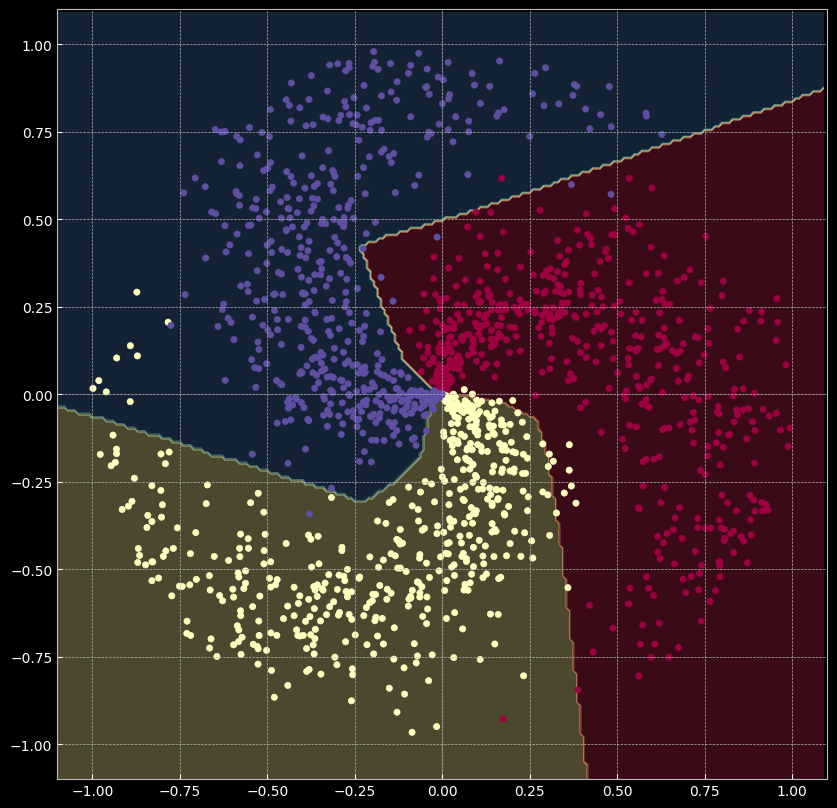

In [72]:
plot_model(X, y, model)

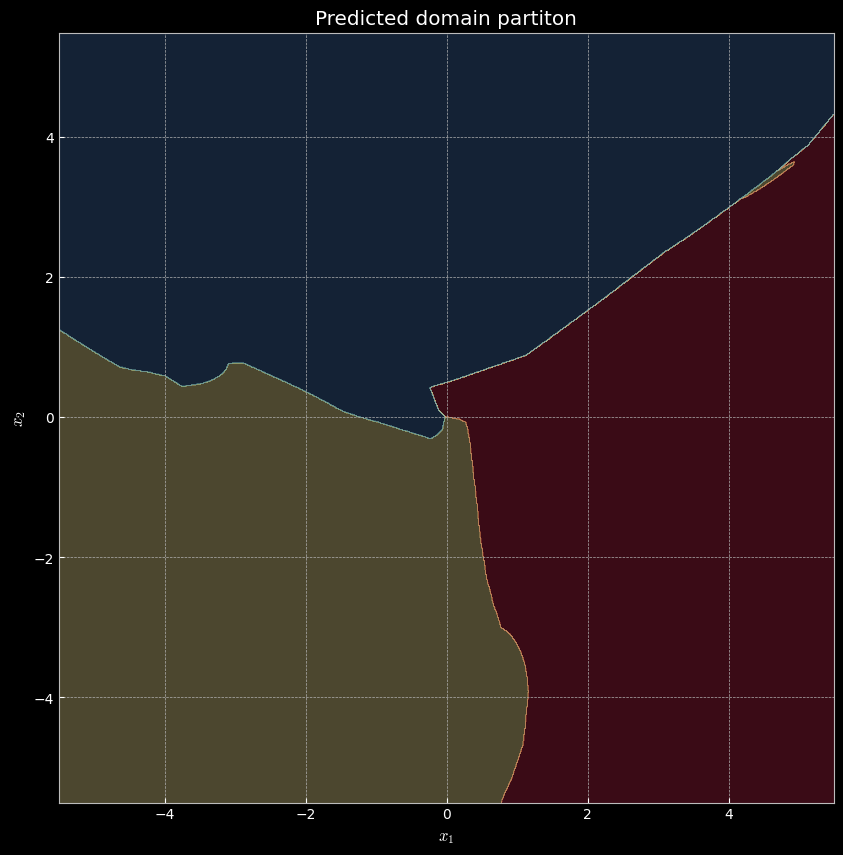

In [73]:
plot_model2(X, y, model)

## Test results

- By Adam: [EPOCH]: 33, [LOSS]: 0.146479, [ACCURACY]: 0.957  with learning_rate = 1e-1
- - By Adam: [EPOCH]: 75, [LOSS]: 0.185647, [ACCURACY]: 0.950 with learning_rate = 1e-2
- By SGD: [EPOCH]: 499, [LOSS]: 0.252418, [ACCURACY]: 0.921 with learning_rate = 1e-1
- By SGD: [EPOCH]: 308, [LOSS]: 0.206772, [ACCURACY]: 0.951 with learning_rate = 0.5

## Selection of an optimiation algorithm from Pytorch

[torch.optim](https://pytorch.org/docs/stable/optim.html#module-torch.optim) is a package implementing various optimization algorithms. For example, we have used

- optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,  weight_decay=lambda_l2) 
- optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

## Selection of loss function in Pytorch

- [cross entropy loss tutorial](https://towardsdatascience.com/cross-entropy-loss-function-f38c4ec8643e)
- [Pytorch document on CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)

In [74]:
for param in model.parameters():
    print(param.size())
    print(type(param.data))

torch.Size([20, 2])
<class 'torch.Tensor'>
torch.Size([20])
<class 'torch.Tensor'>
torch.Size([10, 20])
<class 'torch.Tensor'>
torch.Size([10])
<class 'torch.Tensor'>
torch.Size([10, 10])
<class 'torch.Tensor'>
torch.Size([10])
<class 'torch.Tensor'>
torch.Size([3, 10])
<class 'torch.Tensor'>
torch.Size([3])
<class 'torch.Tensor'>


In [75]:
# Construct a training data set D ={ (x_1, y_1), (x_2, y_2), (x_3, y_3)}
#  with x_i: Row i of the input tensor of 3 by 5
#       y_i: Entry i of the target tensor of 3 
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)

print('input: ', input)
print('target: ', target)

# Select the loss function as the Cross-Entropy loss function
cross_entropy_loss = nn.CrossEntropyLoss()

# 
output = cross_entropy_loss(input, target)

# Computes the gradient of current tensor w.r.t. graph leaves.
output.backward()

print('input: ', input)
print('target: ', target)
print('output: ', output)

input:  tensor([[ 0.8750,  0.8132, -0.0257,  0.7239,  0.9716],
        [-0.7232, -0.1933,  0.2199,  0.2352, -1.9756],
        [-0.3891, -1.2697, -1.1197, -1.4445,  1.2958]], requires_grad=True)
target:  tensor([1, 2, 0])
input:  tensor([[ 0.8750,  0.8132, -0.0257,  0.7239,  0.9716],
        [-0.7232, -0.1933,  0.2199,  0.2352, -1.9756],
        [-0.3891, -1.2697, -1.1197, -1.4445,  1.2958]], requires_grad=True)
target:  tensor([1, 2, 0])
output:  tensor(1.5704, grad_fn=<NllLossBackward0>)
